In [1]:
# === Standardbibliothek ===
import os
import pickle
from pathlib import Path
from pprint import pprint
from typing import Dict, List, Union

# === Drittanbieter-Bibliotheken ===

# Datenverarbeitung, Numerik & Visualisierung
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Hyperparameter-Optimierung
from hyperopt import STATUS_OK, Trials, fmin, hp, space_eval, tpe

# Machine Learning & Experiment-Tracking
import lightgbm as lgb
import mlflow
import mlflow.lightgbm
import mlflow.sklearn
import xgboost as xgb
from mlflow import MlflowClient
from mlflow.data import from_pandas # 'from_pandas' wird hier zusammengefasst
from mlflow.models import infer_signature

# Scikit-learn 
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import  RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, SGDRegressor
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_curve,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier




# Regressionsmodell zur Prognose der Transaktionsgebühren

Dieses Modell dient der Vorhersage der zu erwartenden Gebührenhöhe (Fee) für jeden einzelnen Zahlungsdienstleister (PSP). Diese Vorhersage wird mit der Erfolgswahrscheinlichkeit je PSP kombiniert, um eine Empfehulng für einen PSP auszugeben.

# Evaluierung

Zur Beurteilung der Vorhersagegüte des Regressionsmodells werden die folgenden Kennzahlen herangezogen:

* **Mean Absolute Error (MAE)**
    * **Was es misst:** Den durchschnittlichen absoluten Fehler der Gebührenvorhersage in Euro.
    * **Relevanz für diesen Use Case:** Diese Metrik ist für den Fachbereich direkt interpretierbar. Ein MAE von 0.50€ bedeutet, dass die Prognose im Schnitt um 50 Cent von der tatsächlichen Gebühr abweicht. Sie ist ideal zur Kommunikation der generellen Genauigkeit des Modells.

* **Root Mean Squared Error (RMSE)**
    * **Was es misst:** Die Wurzel aus dem durchschnittlichen quadratischen Fehler, ebenfalls in Euro. Größere Fehler werden hier stärker gewichtet als beim MAE.
    * **Relevanz für diesen Use Case:** Sehr wichtig, um das Risiko von großen, kostspieligen Fehleinschätzungen zu bewerten. Ein Modell mit einem niedrigen RMSE macht seltener grobe Fehler, was für eine stabile Kostenoptimierung und die Vermeidung unerwartet teurer Transaktionen entscheidend ist.

* **Bestimmtheitsmaß (R-Quadrat / R²)**
    * **Was es misst:** Den Anteil der Varianz in den Gebühren, der durch die Features des Modells erklärt werden kann (ein Wert zwischen 0 und 1).
    * **Relevanz für diesen Use Case:** Gibt eine allgemeine Einschätzung, wie gut das Modell die Zusammenhänge in den Daten "verstanden" hat. Ein hoher R²-Wert deutet darauf hin, dass die Features eine gute Vorhersagekraft für die Gebührenhöhe besitzen.
    * R² = 1: Perfekte Vorhersage. Das Modell erklärt 100% der Varianz.
    * R² = 0: Das Modell hat keine Vorhersagekraft.

**Bewertungsstrategie:** Das Ziel ist ein Modell, das einen möglichst niedrigen **MAE** (für die allgemeine Genauigkeit) und einen niedrigen **RMSE** (zur Vermeidung von Ausreißern) kombiniert. R² dient als unterstützende Metrik zur Beurteilung der Gesamt-Passform des Modells.

# Dataframe laden

Dieser Code-Abschnitt lädt die final aufbereiteten DataFrames aus den Pickle-Dateien `df_Regression_reduced.pkl`, `df_Regression_featureSelection.pkl`, `df_Regression_pca_original_features.pkl` und `df_Regression.pkl`. Da beim Speichern und Laden von Daten die spezifischen Datentypen verloren gehen können (z.B. werden aus Zahlen `object`-Typen), wird anschließend ein robuster Konvertierungsprozess durchgeführt.

Zuerst identifiziert und "schützt" der Code alle Spalten, die bereits ein korrektes `datetime`-Format haben. Danach optimiert die Funktion `df.convert_dtypes()` alle anderen Spalten automatisch in den bestmöglichen, speichereffizienten Datentyp. 

Die Funktion `df.convert_dtypes()` ist eine intelligente Methode in Pandas, um die Datentypen eines DataFrames automatisch zu optimieren und in das bestmögliche, speichereffizienteste Format umzuwandeln.

**Was im Detail passiert:**


* Eine `object`-Spalte, die nur Zahlen enthält (z.B. `['1', '2', '3']`), wird in einen numerischen Typ umgewandelt.
* Eine `object`-Spalte, die nur Text enthält, wird in den modernen `string`-Typ umgewandelt, der für Textoperationen optimiert ist.
* Eine `float64`-Spalte, die nur Ganzzahlen enthält (z.B. `[1.0, 2.0, 3.0]`), wird in einen Integer-Typ umgewandelt.

In [2]:
# --- HILFSFUNKTION ZUM LADEN UND KONVERTIEREN ---
def load_and_convert_pickle(pkl_path):
    """
    Lädt eine Pickle-Datei als DataFrame und optimiert sofort die Datentypen,
    während datetime-Spalten geschützt werden.
    """
    try:
        # 1. Pickle-Datei laden
        df = pd.read_pickle(pkl_path)
        print(f"--- DataFrame aus '{pkl_path.name}' geladen ---")
        print("Datentypen VOR der Konvertierung:")
        df.info(verbose=False)

        # 2. Datentypen intelligent konvertieren
        # a) Merke dir, welche Spalten bereits datetime sind
        datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
        
        # b) Führe die allgemeine, automatische Konvertierung durch
        df = df.convert_dtypes()
        
        # c) Stelle sicher, dass die datetime-Spalten ihren Typ behalten haben
        for col in datetime_cols:
            df[col] = pd.to_datetime(df[col])

        print("\nDatentypen NACH der Konvertierung:")
        df.info(verbose=False)
        print("-" * 50)
        
        return df

    except FileNotFoundError:
        print(f"FEHLER: Datei '{pkl_path.name}' nicht im Verzeichnis '{pkl_path.parent}' gefunden.")
        return None
    except Exception as e:
        print(f"FEHLER beim Laden von '{pkl_path.name}': {e}")
        return None

# Pfad-Definitionen
this_dir = Path.cwd()
data_dir = this_dir / ".." / "Data"
data_dir = data_dir.resolve()

# In Jupyter alle Spalten komplett anzeigen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 10)


# 1. df_Regression_reduced.pkl
pkl_path_reduced = data_dir / "df_Regression_reduced.pkl"
df_Regression_reduced = load_and_convert_pickle(pkl_path_reduced) 

# 2. df_Regression_featureSelection.pkl (Dieser Name war bereits korrekt)
pkl_path_fs = data_dir / "df_Regression_featureSelection.pkl"
df_Regression_featureSelection = load_and_convert_pickle(pkl_path_fs)

# 3. df_Regression_pca_original_features.pkl
pkl_path_pca_orig = data_dir / "df_Regression_pca_original_features.pkl"
df_Regression_pca_original_features = load_and_convert_pickle(pkl_path_pca_orig) 

# 4. df_Regression.pkl (Das vollständige/Basis-DF)
pkl_path_full = data_dir / "df_Regression.pkl"
df_Regression = load_and_convert_pickle(pkl_path_full) 

--- DataFrame aus 'df_Regression_reduced.pkl' geladen ---
Datentypen VOR der Konvertierung:
<class 'pandas.core.frame.DataFrame'>
Index: 50329 entries, 0 to 50328
Columns: 15 entries, oh__card_Visa to remainder__fee
dtypes: Float64(3), Int32(3), Int64(9)
memory usage: 6.3 MB

Datentypen NACH der Konvertierung:
<class 'pandas.core.frame.DataFrame'>
Index: 50329 entries, 0 to 50328
Columns: 15 entries, oh__card_Visa to remainder__fee
dtypes: Float64(3), Int32(3), Int64(9)
memory usage: 6.3 MB
--------------------------------------------------
--- DataFrame aus 'df_Regression_featureSelection.pkl' geladen ---
Datentypen VOR der Konvertierung:
<class 'pandas.core.frame.DataFrame'>
Index: 50329 entries, 0 to 50328
Columns: 14 entries, bin__3D_secured to remainder__hour_sin
dtypes: Float64(3), Int32(3), Int64(8)
memory usage: 5.9 MB

Datentypen NACH der Konvertierung:
<class 'pandas.core.frame.DataFrame'>
Index: 50329 entries, 0 to 50328
Columns: 14 entries, bin__3D_secured to remainder__hou

## MLFlow einrichten

MLflow ist eine Open-Source-Plattform zur Verwaltung des gesamten Machine-Learning-Lebenszyklus. Wir setzen MLflow ein, um alle unsere Experimente, inklusive der verwendeten Parameter, Code-Versionen und resultierenden Metriken wie AUC oder Precision, systematisch zu protokollieren. Dies garantiert die Reproduzierbarkeit unserer Ergebnisse und ermöglicht einen klaren, visuellen Vergleich der verschiedenen Modelle und Datenansätze, um fundierte Entscheidungen zu treffen.

**In Powershell den Tracking-Server mit folgendem Befehl starten:**
`mlflow server --host 127.0.0.1 --port 8080`

In [3]:
# Startet den Befehl in einem neuen, minimierten Konsolenfenster
!start /B mlflow server --host 127.0.0.1 --port 8080

In [4]:
# --- Konfiguration ---
tracking_uri   = "http://127.0.0.1:8080"

# --- Setup Tracking + Client ---
mlflow.set_tracking_uri(tracking_uri)
client = MlflowClient()

# Baseline Modell

Die lineare Regression wird als robustes Baseline-Modell eingesetzt, um einen grundlegenden Leistungs-Benchmark zu etablieren. Dieser dient als Referenzwert: Jedes komplexere Modell muss diesen Wert signifikant übertreffen, um seine zusätzliche Komplexität zu rechtfertigen.

Gleichzeitig wird die Baseline genutzt, um die Vorhersagekraft der unterschiedlichen vorbereiteten Datensätze (Feature-Sets) zu vergleichen und die effektivste Datenbasis für die weitere Modellierung zu identifizieren.

In [5]:
experiment_name = "Regression_Baseline"

experiment_description = (
    "This experiment is concerned with a Baseline Regression Model to predict the fee for different PsP Services in a Banking Transfer Process."
)

experiment_tags = {
    "project_name": "Regression_Baseline",
    "mlflow.note.content": experiment_description,
}

# --- Run/Artefakt-Basics ---
run_name = "Regression_Baseline"
artifact_path = "Regression_Baseline"


In [37]:
def run_regression_experiment(df, df_name, pkl_file_name, target="remainder__fee"):
    """Führt ein Regressions-Experiment durch und loggt die Ergebnisse mit MLflow."""
    
    print("-" * 60)
    print(f"Starte MLflow Run für Regressionsmodell: {df_name}")

    # 1. Datenvorbereitung (Target und Features)
    if target not in df.columns:
        print(f"FEHLER: Die Zielspalte '{target}' wurde im DataFrame '{df_name}' nicht gefunden. Überspringe...")
        return

    X = df.drop(columns=[target])
    y = df[target]

    # Integer-Features robust machen
    int_cols = X.select_dtypes(include=["int8","int16","int32","int64","uint8","uint16","uint32","uint64"]).columns
    if len(int_cols) > 0:
        X[int_cols] = X[int_cols].astype("float64")

    # 2. Split (ohne 'stratify')
    test_size = 0.2
    random_state = 42
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # 3. Parameter und Modell (LinearRegression)
    params = {
        "Model": "LinearRegression",
        "test_size": test_size,
        "random_state": random_state,
        "n_features": X.shape[1],
        "dataframe_source": pkl_file_name
    }

    model = LinearRegression()
    model.fit(X_train, y_train)

    # 4. Vorhersagen (mit .predict())
    pred_tr = model.predict(X_train)
    pred_te = model.predict(X_val)

    # 5. Regressions-Metriken berechnen
    metrics = {
        "train_mae": mean_absolute_error(y_train, pred_tr),
        "train_mse": mean_squared_error(y_train, pred_tr),
        "train_rmse": np.sqrt(mean_squared_error(y_train, pred_tr)),
        "train_r2": r2_score(y_train, pred_tr),
        "val_mae": mean_absolute_error(y_val, pred_te),
        "val_mse": mean_squared_error(y_val, pred_te),
        "val_rmse": np.sqrt(mean_squared_error(y_val, pred_te)),
        "val_r2": r2_score(y_val, pred_te),
    }
    metrics = {k: np.round(v, 3) for k, v in metrics.items()}

    # 6. MLflow Logging
    artifact_path = "linear_regression_model"
    pkl_path_full = Path(pkl_file_name).resolve()

    with mlflow.start_run(run_name=f"{df_name}_Regression_Baseline"):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)

        train_ds = from_pandas(
            X_train.assign(**{target: y_train}), source=pkl_path_full.as_uri(),
            name=f"PSP_Fee_{df_name}_Train", targets=target
        )
        mlflow.log_input(train_ds, context="training")

        val_ds = from_pandas(
            X_val.assign(**{target: y_val}), source=pkl_path_full.as_uri(),
            name=f"PSP_Fee_{df_name}_Val", targets=target
        )
        mlflow.log_input(val_ds, context="validation")

        signature = infer_signature(X_train, pred_tr)
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path=artifact_path,
            input_example=X_val.head(5),
            signature=signature
        )

        print(f"MLflow Run beendet. Val R2: {metrics['val_r2']}, Val RMSE: {metrics['val_rmse']}")
        print("-" * 60)


experiment_name = "Regression_Baseline" 
mlflow.set_experiment(experiment_name)

# Liste der Regressions-DataFrames, die verarbeitet werden sollen
dataframes_to_process_regr = [
    # KORRIGIERT: Die Zeile wurde auf die korrekte Tupel-Struktur (Variable, "Name", "Dateiname") repariert.
    (df_Regression_reduced, "df_Regression_reduced", "df_Regression_reduced.pkl"),
    (df_Regression_featureSelection, "df_Regression_featureSelection", "df_Regression_featureSelection.pkl"),
    (df_Regression_pca_original_features, "df_Regression_pca_original_features", "df_Regression_pca_original_features.pkl"),
    (df_Regression, "df_Regression_full", "df_Regression.pkl"),
]

# Führe das Experiment für jeden DataFrame aus
for df, df_name, pkl_file in dataframes_to_process_regr:
    # Nur ausführen, wenn das DataFrame erfolgreich geladen wurde
    if df is not None and not df.empty:
        # Hier habe ich als Zielvariable 'remainder__fee' statt 'remainder__fee_scaled' eingesetzt
        run_regression_experiment(df, df_name, pkl_file, target="remainder__fee")
    else:
        print(f"WARNUNG: DataFrame '{df_name}' ist leer oder konnte nicht geladen werden. Überspringe den Lauf.")

------------------------------------------------------------
Starte MLflow Run für Regressionsmodell: df_Regression_reduced


c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'file:///C:/Projects/iu/Model_Engineering/GitPrdner/model/df_Regression_reduced.pkl'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'file:///C:/Projects/iu/Model_Engineering/GitPrdne

MLflow Run beendet. Val R2: 0.697, Val RMSE: 0.996
------------------------------------------------------------
🏃 View run df_Regression_reduced_Regression_Baseline at: http://127.0.0.1:8080/#/experiments/297198823348246718/runs/aca0f674368d4b7ca1ba96d908483633
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/297198823348246718
------------------------------------------------------------
Starte MLflow Run für Regressionsmodell: df_Regression_featureSelection


c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'file:///C:/Projects/iu/Model_Engineering/GitPrdner/model/df_Regression_featureSelection.pkl'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'file:///C:/Projects/iu/Model_Engineering

MLflow Run beendet. Val R2: 0.697, Val RMSE: 0.996
------------------------------------------------------------
🏃 View run df_Regression_featureSelection_Regression_Baseline at: http://127.0.0.1:8080/#/experiments/297198823348246718/runs/554cc0a711b74e2a8b5a3a7a59b21bb6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/297198823348246718
------------------------------------------------------------
Starte MLflow Run für Regressionsmodell: df_Regression_pca_original_features


c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'file:///C:/Projects/iu/Model_Engineering/GitPrdner/model/df_Regression_pca_original_features.pkl'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'file:///C:/Projects/iu/Model_Engine

MLflow Run beendet. Val R2: 0.697, Val RMSE: 0.996
------------------------------------------------------------
🏃 View run df_Regression_pca_original_features_Regression_Baseline at: http://127.0.0.1:8080/#/experiments/297198823348246718/runs/52dec5d3b5b94a0f9aa901c3c8cef88e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/297198823348246718
------------------------------------------------------------
Starte MLflow Run für Regressionsmodell: df_Regression_full


c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'file:///C:/Projects/iu/Model_Engineering/GitPrdner/model/df_Regression.pkl'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'file:///C:/Projects/iu/Model_Engineering/GitPrdner/model/

MLflow Run beendet. Val R2: 0.697, Val RMSE: 0.996
------------------------------------------------------------
🏃 View run df_Regression_full_Regression_Baseline at: http://127.0.0.1:8080/#/experiments/297198823348246718/runs/10c37089a7654796a72d5d49398d4ef6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/297198823348246718


## Interpretation

Die Analyse in MLflow zeigt, dass alle vier getesteten Datensätze identische Performance erzielen. 
Der entscheidende Faktor für die Auswahl ist daher die Anzahl der Features. Der Datensatz `df_Regression_featureSelection` erreicht die gleichen Ergebnisse mit der geringsten Spaltenanzahl. 

**Zusammenfassung der Validierungsergebnisse von df_Regression_featureSelection_Regression_Baseline - 554cc0a711b74e2a8b5a3a7a59b21bb6:**

* **R² (Bestimmtheitsmaß):** Der Validierungs-R²-Wert von **0.697** zeigt, dass das Modell fast 70% der Varianz in der Transaktionsgebühr (`remainder__fee`) erklären kann.
* **RMSE (Wurzel des mittleren quadratischen Fehlers):** Der Validierungs-RMSE-Wert von **0.996** ist sehr nah am Trainingswert (0.978), was auf **kein signifikantes Overfitting** hindeutet.

| Metric | Value |
| :--- | :--- |
| **train\_mae** | 0.676 |
| **train\_mse** | 0.957 |
| **train\_r2** | 0.710 |
| **train\_rmse** | 0.978 |
| **val\_mae** | 0.693 |
| **val\_mse** | 0.991 |
| **val\_r2** | 0.697 |
| **val\_rmse** | 0.996 |





# Auswahl finales Regressionsmodell

Nachdem wir mit der **linearen Regression** eine Baseline-Performance etabliert und den zu verwendenden Datensatz identifiziert haben, folgt nun das Training und die Evaluation anspruchsvollerer Modelle. Wir vergleichen eine Palette von Regressionen, um herauszufinden, welche Modellarchitektur die Beziehungen in unseren Daten am besten erfassen kann. Ziel dieses Schrittes ist es, das Modell mit der höchsten Performance nach Durchführung von Hyperparameter-Tuning zu finden, wobei der Fokus auf der Maximierung von **R²** und der Minimierung von **RMSE** liegt.

* **`MAX_EVALS`** legt die **maximale Anzahl an Durchläufen** fest. Es ist die exakte Anzahl an verschiedenen Hyperparameter-Kombinationen, die während der Optimierung getestet werden (z.B. 40).

* **Der Hyperopt-Algorithmus (TPE)** ist die **optimierte Suchmethode**. Anstatt zufällige Kombinationen zu testen, verwendet dieser Algorithmus die Ergebnisse der vorherigen Durchläufe, um gezielt die Parameterbereiche zu untersuchen, die am wahrscheinlichsten zu einer Leistungsverbesserung führen.

* **Ridge-Regression:**
    * **Was es ist:** Eine lineare Regression mit einer "L2-Regularisierung". Das bedeutet, das Modell bestraft sehr hohe Koeffizienten (Gewichte) für Features.
    * **Vorteil:** Sehr robust, wenn viele Ihrer Features miteinander korrelieren (Multikollinearität).
    * **Klasse:** `sklearn.linear_model.Ridge`

* **LightGBM (LGBM):**
    * **Was es ist:** Ein von Microsoft entwickeltes Gradient-Boosting-Framework. Es ist der wichtigste Konkurrent von XGBoost.
    * **Vorteil:** In der Regel **deutlich schneller** als XGBoost. Es kann oft eine leicht bessere oder vergleichbare Genauigkeit erzielen. 
    * **Klasse:** `lightgbm.LGBMRegressor`

* **RandomForestRegressor**
    * **Was es ist:** Ein Ensemble-Modell, das eine große Anzahl von einzelnen Entscheidungsbäumen (Decision Trees) trainiert und deren einzelne Vorhersagen zu einem stabileren Mittelwert zusammenfasst. Es ist die Regressions-Variante des  bekannten `RandomForestClassifier`.
    * **Vorteil:** Sehr robust gegen Overfitting und oft schon ohne aufwändiges Tuning sehr leistungsstark. Kann komplexe, nicht-lineare Zusammenhänge in den Daten gut erfassen.
    * **Klasse:** `sklearn.ensemble.RandomForestRegressor`

* **SGDRegressor**
    * **Was es ist:** Diese Modelle starten mit einer zufälligen "Linie" und passen diese in vielen kleinen Schritten ("Durchläufen" oder "Epochen") immer weiter an, um den Fehler zu minimieren.
    * **Vorteil:** Sehr effizient und skalierbar für extrem große Datensätze, da es die Daten Punkt für Punkt (oder in kleinen Batches) verarbeitet. Bietet zudem große Flexibilität durch verschiedene Verlustfunktionen und Regularisierungs-Optionen in einem einzigen Modell.
    * **Klasse:** `sklearn.linear_model.SGDRegressor`

* **PolynomialRegression**
    * **Was es ist:** Genau genommen kein eigenständiges Modell, sondern ein **Feature-Engineering-Schritt**. Es erzeugt neue, polynomische Features aus den bestehenden (z.B. aus `x` werden `x²`, `x³` etc.). Auf diesen neuen Features wird dann eine `LinearRegression` trainiert.
    * **Vorteil:** Ermöglicht es einem einfachen linearen Modell, nicht-lineare, kurvenförmige Zusammenhänge in den Daten zu modellieren.
    * **Klasse:** Wird meist in einer Pipeline verwendet: `sklearn.preprocessing.PolynomialFeatures` + `sklearn.linear_model.LinearRegression`.

In [6]:
experiment_name = "Regression_Model__featureSelection_df"

experiment_description = (
    "This experiment is concerned with the Regression Model to predict the fee for different PsP Services in a Banking Transfer Process."
)

experiment_tags = {
    "project_name": "Regression_Model_reduced_df",
    "mlflow.note.content": experiment_description,
}

In [7]:
RANDOM_STATE = 42
MAX_EVALS = 40

target = "remainder__fee"
X = df_Regression_featureSelection.drop(columns=[target]).astype("float64")
y = df_Regression_featureSelection[target].astype(int).to_numpy()
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
print("Daten vorbereitet:", X_train.shape, X_val.shape)

Daten vorbereitet: (40263, 13) (10066, 13)


In [8]:
def compute_regression_metrics(y_true, y_pred, prefix=""):
    """
    Berechnet die wichtigsten Regressions-Metriken für ein gegebenes Set von wahren Werten und Vorhersagen.
    """
    # Berechne Metriken
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Runde und gib die Metriken als Dictionary zurück
    return {
        f"{prefix}mae": round(mae, 3),
        f"{prefix}mse": round(mse, 3),
        f"{prefix}rmse": round(rmse, 3),
        f"{prefix}r2": round(r2, 3),
    }


# SGD Regression

In [41]:
# SGD ist sehr empfindlich auf die Skalierung der Features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
print("Trainings- und Validierungsdaten wurden skaliert.")

# === SUCHRAUM (ANGEPASST FÜR SGDREGRESSOR) ===
space = {
    'loss': hp.choice('loss', ['squared_error', 'huber', 'epsilon_insensitive']),
    'penalty': hp.choice('penalty', ['l2', 'l1', 'elasticnet']),
    'alpha': hp.loguniform('alpha', np.log(1e-5), np.log(1e-1)),
    'learning_rate': hp.choice('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
    'eta0': hp.loguniform('eta0', np.log(1e-4), np.log(1e-1)), # Initiale Lernrate bei 'constant', 'invscaling', 'adaptive'
    'max_iter': hp.quniform('max_iter', 500, 2000, 100), # Anzahl der Epochen
}

# === TRAININGS- UND EVALUIERUNGSFUNKTION (ANGEPASST FÜR SGD) ===
def train_eval_sgd(params):
    params['max_iter'] = int(params['max_iter'])
    
    # Erstelle das Modell mit den Parametern aus der Hyperopt-Suche
    model = SGDRegressor(**params, random_state=RANDOM_STATE)
    
    # WICHTIG: Trainiere auf den skalierten Daten!
    model.fit(X_train_scaled, y_train)

    # Mache Vorhersagen ebenfalls auf den skalierten Daten
    pred_tr = model.predict(X_train_scaled)
    pred_te = model.predict(X_val_scaled)

    m_tr = compute_regression_metrics(y_train, pred_tr, prefix="train_")
    m_te = compute_regression_metrics(y_val, pred_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    
    return model, metrics

# === OBJECTIVE-FUNKTION (ANGEPASST FÜR SGD) ===
def objective_sgd(params):
    with mlflow.start_run(nested=True):
        mlflow.log_param("Model", "SGDRegressor")
        mlflow.log_param("metric", "rmse")
        mlflow.log_params(params)
        
        model, metrics = train_eval_sgd(params)
        
        mlflow.log_metrics(metrics)
        # Signatur wird mit den unskalierten Daten erstellt, um die ursprüngliche Struktur zu zeigen
        sig = infer_signature(X_train, model.predict(X_train_scaled))
        mlflow.sklearn.log_model(model, "model", signature=sig)
        
        return {"loss": metrics["val_rmse"], "status": STATUS_OK}

# === EXPERIMENT AUSFÜHREN (ANGEPASST FÜR SGD) ===
def run_hyperopt_sgd():
    mlflow.set_experiment(experiment_name)
    
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    with mlflow.start_run(run_name="sgd-hyperopt-rmse") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS, "metric": "rmse"})
        
        best = fmin(fn=objective_sgd, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        
        best_loss = trials.best_trial['result']['loss']
        mlflow.log_metrics({"best_val_rmse": best_loss})

        best_params = space_eval(space, best)
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        
        print("\nBester gefundener Run:")
        print(f"Bester RMSE: {best_loss:.4f}")
        print("Beste Parameter:", best_params)

    return best_params, best_loss

# === AUSFÜHRUNG ===
best_params_sgd, best_rmse_sgd = run_hyperopt_sgd()

Trainings- und Validierungsdaten wurden skaliert.
  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001003 seconds
INFO:hyperopt.tpe:TPE using 0 trials


🏃 View run peaceful-boar-440 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/52e2f6026a9144c58080d502ff40dfaa

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  2%|▎         | 1/40 [00:03<02:02,  3.14s/trial, best loss: 1.154]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001106 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.154000


🏃 View run funny-midge-228 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/f6bb68f3f36a417aba6b4a925d4bdf66

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  5%|▌         | 2/40 [00:06<01:57,  3.10s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001015 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.993000


🏃 View run traveling-perch-16 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/69c74c5ac4754b38bde934e5db019205

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  8%|▊         | 3/40 [00:09<01:54,  3.09s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.993000


🏃 View run mysterious-gnat-521 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/8546c8c0fe1e4850a9db740d143d1d78

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 10%|█         | 4/40 [00:12<01:50,  3.07s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001004 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.993000


🏃 View run salty-asp-152 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/42d2e4efa4fc46b6ae853c4719e109a1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 12%|█▎        | 5/40 [00:15<01:46,  3.05s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002516 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.993000


🏃 View run respected-shad-226 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/fe358317b5374675b54adef567c37128

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 15%|█▌        | 6/40 [00:18<01:45,  3.11s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001698 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.993000


🏃 View run salty-mare-354 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/72fa43eb915742f3bceae2011dd72297

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 18%|█▊        | 7/40 [00:21<01:42,  3.09s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001074 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.993000


🏃 View run luminous-gnat-830 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/cdc1ef37b2ab4c49a4f86d915756d2ed

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 20%|██        | 8/40 [00:25<01:41,  3.18s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.993000


🏃 View run glamorous-pig-302 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/a11505e7a0634887af4da8c8609d66e9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 22%|██▎       | 9/40 [00:28<01:39,  3.22s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000661 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.993000


🏃 View run illustrious-mule-406 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/38031c2dea6b406ba388a8011f0d55c2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 25%|██▌       | 10/40 [00:31<01:39,  3.33s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000987 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 0.993000


🏃 View run capable-chimp-343 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/77267004f3d4402b80a8076d9132e52e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 28%|██▊       | 11/40 [00:36<01:47,  3.70s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003471 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 0.993000


🏃 View run respected-crab-287 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/66e96670b436435f8d81a3c425ea9991

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 30%|███       | 12/40 [00:43<02:08,  4.60s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004004 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 0.993000


🏃 View run bedecked-hound-781 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/c32499fab68a4691b3c56fda3b096e9f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 32%|███▎      | 13/40 [00:48<02:09,  4.79s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 0.993000


🏃 View run rogue-fowl-449 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/4427a229578d4677a2d8447d55141bb4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 35%|███▌      | 14/40 [00:53<02:05,  4.82s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 0.993000


🏃 View run selective-mink-64 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/3233ae177d364dd59c3d0af871ace53f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 38%|███▊      | 15/40 [00:58<02:02,  4.92s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007005 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 0.993000


🏃 View run masked-hare-995 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/a5034ce59b824edcad546ce99ce46485

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 40%|████      | 16/40 [01:03<01:56,  4.87s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002470 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 0.993000


🏃 View run amazing-fly-413 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/8dffd059f8684b229c305e79c1b970d7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 42%|████▎     | 17/40 [01:08<01:56,  5.06s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 0.993000


🏃 View run handsome-lark-871 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/56691f58ac4c44dfa87f774429a7e3f1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 45%|████▌     | 18/40 [01:13<01:52,  5.13s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002119 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 0.993000


🏃 View run unleashed-fish-294 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/94f7f65ec3e74b71bec09265529c1d0f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 48%|████▊     | 19/40 [01:18<01:46,  5.05s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 0.993000


🏃 View run kindly-conch-361 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/0711b789ae8047a68d68fee75c57dc06

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 50%|█████     | 20/40 [01:23<01:41,  5.05s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001989 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 0.993000


🏃 View run colorful-shrew-961 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/190320c18f084bc794d3c28178e056b2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 52%|█████▎    | 21/40 [01:29<01:42,  5.38s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.016000 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 0.993000


🏃 View run bustling-eel-322 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/6c7a97212be24207b9c3c28ba8732c17

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 55%|█████▌    | 22/40 [01:36<01:44,  5.82s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001971 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 0.993000


🏃 View run brawny-bug-96 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/e963130e16c145b7a572c5c8134bb5fe

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 57%|█████▊    | 23/40 [01:41<01:30,  5.35s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001009 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 0.993000


🏃 View run painted-trout-533 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/c27c15ab55544187825a8677a6e6e84e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 60%|██████    | 24/40 [01:45<01:19,  4.96s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002004 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 0.993000


🏃 View run receptive-perch-100 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/3d20c07277ae41baba5e7a5166684bde

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 62%|██████▎   | 25/40 [01:49<01:12,  4.81s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss 0.993000


🏃 View run valuable-zebra-185 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/19a74a661cca41d9b170db238d8464c1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 65%|██████▌   | 26/40 [01:54<01:08,  4.90s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss 0.993000


🏃 View run angry-yak-896 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/da158f672c2d48df9217f193d3f467a6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 68%|██████▊   | 27/40 [01:59<01:03,  4.91s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002892 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss 0.993000


🏃 View run bouncy-rook-542 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/fae6c124b84243a3b8c9e1f395d1565f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 70%|███████   | 28/40 [02:04<00:57,  4.79s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001048 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss 0.993000


🏃 View run delicate-shad-287 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/899064fd1c6848df85a881cb83f75038

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 72%|███████▎  | 29/40 [02:08<00:51,  4.66s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002007 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss 0.993000


🏃 View run luxuriant-bug-532 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/669db974100343908c1fb3948ea383f2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 75%|███████▌  | 30/40 [02:12<00:46,  4.60s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002996 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss 0.993000


🏃 View run nimble-hog-404 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/a902ef9d5257428abb7d12d8be2310af

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 78%|███████▊  | 31/40 [02:17<00:41,  4.58s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss 0.993000


🏃 View run redolent-bass-962 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/e6f8f90d98784258ae86902d4e4ed2dc

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 80%|████████  | 32/40 [02:22<00:37,  4.65s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002020 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss 0.993000


🏃 View run sincere-snipe-424 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/51a39400fa29430d8d11cf177180c222

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 82%|████████▎ | 33/40 [02:26<00:32,  4.58s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001962 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss 0.993000


🏃 View run powerful-rook-539 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/ee617c3c552b4c368df693395f75b75a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 85%|████████▌ | 34/40 [02:31<00:27,  4.61s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005993 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss 0.993000


🏃 View run vaunted-sloth-595 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/4fd3c47aa0e74ad29e2814c39edb1e39

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 88%|████████▊ | 35/40 [02:35<00:22,  4.50s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003008 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss 0.993000


🏃 View run youthful-worm-542 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/e57b7cea9a09457aaa7f278348250ad8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 90%|█████████ | 36/40 [02:40<00:17,  4.47s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss 0.993000


🏃 View run aged-crane-299 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/5718da3a9b0746b5abcabf64f9cf269f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 92%|█████████▎| 37/40 [02:44<00:13,  4.35s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003036 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss 0.993000


🏃 View run welcoming-goose-666 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/b59c5914e39c4a938afa7346d640d4f3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 95%|█████████▌| 38/40 [02:48<00:08,  4.24s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000994 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss 0.993000


🏃 View run unique-goat-269 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/4e30e26be81949d0a2751c76a561e20e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 98%|█████████▊| 39/40 [02:52<00:04,  4.23s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss 0.993000


🏃 View run chill-kit-7 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/41e3648bda3b42329ac79059c2bf947a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

100%|██████████| 40/40 [02:56<00:00,  4.42s/trial, best loss: 0.993]

Bester gefundener Run:
Bester RMSE: 0.9930
Beste Parameter: {'alpha': 0.0018044885156420084, 'eta0': 0.00015128942324738016, 'learning_rate': 'adaptive', 'loss': 'squared_error', 'max_iter': 1400.0, 'penalty': 'elasticnet'}
🏃 View run sgd-hyperopt-rmse at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/8956b2c988904ed5ae7e5e21c462be55
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983


# RandomForestRegressor 

In [42]:
# === SUCHRAUM (ANGEPASST FÜR RANDOM FOREST) ===
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 25), # Anzahl der Bäume
    'max_depth': hp.quniform('max_depth', 10, 30, 2),        # Max. Tiefe der Bäume
    'max_features': hp.choice('max_features', ['sqrt', 'log2']), # Anzahl Features pro Split
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1), # Min. Samples für Split
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),   # Min. Samples pro Blatt
}

# === TRAININGS- UND EVALUIERUNGSFUNKTION (ANGEPASST FÜR RANDOM FOREST) ===
def train_eval_rf(params):
    # Konvertiere float-Werte von Hyperopt zu int, wo nötig
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    
    # Erstelle das Modell mit den Parametern und nutze alle CPU-Kerne (n_jobs=-1)
    model = RandomForestRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)
    model.fit(X_train, y_train)

    pred_tr = model.predict(X_train)
    pred_te = model.predict(X_val)

    m_tr = compute_regression_metrics(y_train, pred_tr, prefix="train_")
    m_te = compute_regression_metrics(y_val, pred_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    
    return model, metrics

# === OBJECTIVE-FUNKTION (ANGEPASST FÜR RANDOM FOREST) ===
def objective_rf(params):
    with mlflow.start_run(nested=True):
        mlflow.log_param("Model", "RandomForestRegressor")
        mlflow.log_param("metric", "rmse")
        mlflow.log_params(params)
        
        model, metrics = train_eval_rf(params)
        
        mlflow.log_metrics(metrics)
        sig = infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(model, "model", signature=sig)
        
        # Optimiere auf den RMSE des Validierungs-Sets
        return {"loss": metrics["val_rmse"], "status": STATUS_OK}

# # === EXPERIMENT AUSFÜHREN (ANGEPASST FÜR RANDOM FOREST) ===
def run_hyperopt_rf():
    mlflow.set_experiment(experiment_name)
    
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    with mlflow.start_run(run_name="randomforest-hyperopt-rmse") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS, "metric": "rmse"})
        
        best = fmin(fn=objective_rf, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        
        best_loss = trials.best_trial['result']['loss']
        mlflow.log_metrics({"best_val_rmse": best_loss})

        best_params = space_eval(space, best)
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        
        print("\nBester gefundener Run:")
        print(f"Bester RMSE: {best_loss:.4f}")
        print("Beste Parameter:", best_params)

    return best_params, best_loss

# # === AUSFÜHRUNG ===
best_params_rf, best_rmse_rf = run_hyperopt_rf()

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000993 seconds
INFO:hyperopt.tpe:TPE using 0 trials


🏃 View run nosy-goat-47 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/a8cba58cd8274fac83eab97a735929d0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  2%|▎         | 1/40 [00:09<06:04,  9.36s/trial, best loss: 0.988]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.988000


🏃 View run secretive-skunk-612 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/af575b67e2d644cbbe86569a2a87209a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  5%|▌         | 2/40 [00:15<04:50,  7.65s/trial, best loss: 0.988]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001944 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.988000


🏃 View run overjoyed-foal-901 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/a5ed4a0f146b4688a3115146ae1bde83

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  8%|▊         | 3/40 [00:21<04:08,  6.71s/trial, best loss: 0.988]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001986 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.988000


🏃 View run unequaled-skink-740 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/ee2d5e3578f846c3ad0a7fe89fc452ac

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 10%|█         | 4/40 [00:28<04:01,  6.71s/trial, best loss: 0.983]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001043 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.983000


🏃 View run victorious-colt-980 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/214a20c9cca5413392a2524201c6d211

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 12%|█▎        | 5/40 [00:36<04:21,  7.47s/trial, best loss: 0.983]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000893 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.983000


🏃 View run bold-dog-99 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/52754ec2290f4126a704d9e166f1dced

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 15%|█▌        | 6/40 [00:46<04:42,  8.31s/trial, best loss: 0.983]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.983000


🏃 View run incongruous-roo-425 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/1f2576714a034186bb5b2c131abb4c30

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 18%|█▊        | 7/40 [00:56<04:50,  8.80s/trial, best loss: 0.983]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.983000


🏃 View run spiffy-trout-716 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/ebe2e606e5124529a2e1a199e2a6e8ee

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 20%|██        | 8/40 [01:02<04:10,  7.83s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002073 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.982000


🏃 View run shivering-colt-861 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/23b0c68b2da548ca9c0c7c092b648211

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 22%|██▎       | 9/40 [01:13<04:37,  8.96s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.982000


🏃 View run nervous-roo-128 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/10f799466b50455ea38ceeece24f92ca

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 25%|██▌       | 10/40 [01:21<04:15,  8.52s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 0.982000


🏃 View run melodic-moose-460 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/40b11a9747d540d4bf86b1ffec16a17c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 28%|██▊       | 11/40 [01:27<03:47,  7.86s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 0.982000


🏃 View run vaunted-dog-124 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/fef7fe3226334071a9d251df1b721122

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 30%|███       | 12/40 [01:37<03:51,  8.28s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000997 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 0.982000


🏃 View run unleashed-asp-993 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/6076bb2a791944188149909055be9de9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 32%|███▎      | 13/40 [01:44<03:37,  8.06s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 0.982000


🏃 View run monumental-wolf-613 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/2323cbe6f04546209c5072f2a7203f48

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 35%|███▌      | 14/40 [01:51<03:20,  7.71s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 0.982000


🏃 View run mysterious-hound-378 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/9accf7f6d1f643a69792ea5c51e994a8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 38%|███▊      | 15/40 [01:57<03:02,  7.31s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001135 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 0.982000


🏃 View run stately-worm-980 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/031ebe4c4477417aa4ecee2b8a89ac38

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 40%|████      | 16/40 [02:09<03:25,  8.57s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 0.982000


🏃 View run agreeable-finch-101 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/8f7f49a292da4c84bf6b024e0c0f0463

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 42%|████▎     | 17/40 [02:18<03:21,  8.76s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 0.982000


🏃 View run amusing-mare-421 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/ec5eebb2024c431b899f23b341f5c397

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 45%|████▌     | 18/40 [02:24<02:53,  7.90s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002989 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 0.982000


🏃 View run secretive-goose-268 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/4050e4eb658b438a8919b8d2107aa3d4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 48%|████▊     | 19/40 [02:30<02:35,  7.41s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 0.982000


🏃 View run resilient-skunk-26 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/5dad5fecca8f447b97c7b69dde111923

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 50%|█████     | 20/40 [02:37<02:22,  7.12s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 0.982000


🏃 View run sneaky-cow-92 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/17287e1251e24510a2494c7e9799a632

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 52%|█████▎    | 21/40 [02:43<02:09,  6.82s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001050 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 0.979000


🏃 View run hilarious-cow-860 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/b8ccc85e17b14514935153b1c44efc08

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 55%|█████▌    | 22/40 [02:53<02:21,  7.87s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002348 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 0.979000


🏃 View run learned-yak-55 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/4baff2af13e74ae9b0a6d769b5e7d794

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 57%|█████▊    | 23/40 [03:01<02:16,  8.02s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001507 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 0.979000


🏃 View run suave-fish-354 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/f0d360b3878c4d18970b1f1ed96daf92

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 60%|██████    | 24/40 [03:11<02:15,  8.49s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 0.979000


🏃 View run enchanting-goat-143 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/eb282a55bf454e5a924bb3bcb3a5e3c6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 62%|██████▎   | 25/40 [03:21<02:15,  9.04s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003013 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss 0.979000


🏃 View run aged-bear-535 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/19245d9708914b65881c6c92e7d1f607

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 65%|██████▌   | 26/40 [03:33<02:17,  9.81s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss 0.979000


🏃 View run clumsy-penguin-134 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/581328f636ee42cda3f25657bc9e7d2e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 68%|██████▊   | 27/40 [03:43<02:10, 10.00s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss 0.979000


🏃 View run stately-mouse-314 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/d0d291a0e8064b2a81f5153c92529a93

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 70%|███████   | 28/40 [03:50<01:46,  8.91s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000997 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss 0.979000


🏃 View run fortunate-whale-685 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/df8baaa401c049409b7a11477ece1af0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 72%|███████▎  | 29/40 [03:57<01:33,  8.53s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001487 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss 0.979000


🏃 View run adventurous-eel-672 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/2551832d84f949369240f72ae094e30c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 75%|███████▌  | 30/40 [04:07<01:29,  8.97s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002010 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss 0.979000


🏃 View run bouncy-fawn-670 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/74a3bc5fc2274428915306be3e7b70d2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 78%|███████▊  | 31/40 [04:15<01:17,  8.64s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002075 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss 0.979000


🏃 View run bittersweet-vole-594 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/d11dc930ca9346feba5ada7db685ed3f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 80%|████████  | 32/40 [04:25<01:11,  8.94s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002006 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss 0.979000


🏃 View run trusting-shad-652 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/70189352c9bc412b9018490c846ff5d3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 82%|████████▎ | 33/40 [04:36<01:07,  9.63s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss 0.979000


🏃 View run marvelous-donkey-374 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/9f74a30d59d34318925b530358d5464b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 85%|████████▌ | 34/40 [04:44<00:55,  9.21s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001119 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss 0.979000


🏃 View run rogue-croc-295 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/3c83745321084dd3b2bc8f504dc823aa

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 88%|████████▊ | 35/40 [04:55<00:47,  9.55s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss 0.979000


🏃 View run agreeable-elk-653 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/8584aba9f939413e9215fd33e92dd038

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 90%|█████████ | 36/40 [05:02<00:35,  8.92s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss 0.979000


🏃 View run thundering-sheep-96 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/2c3e52145de443f09efc23c6214fc027

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 92%|█████████▎| 37/40 [05:12<00:27,  9.10s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001948 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss 0.979000


🏃 View run overjoyed-bee-354 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/99a456d4e40c4e7c832c62db625002d7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 95%|█████████▌| 38/40 [05:19<00:17,  8.59s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001957 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss 0.979000


🏃 View run skittish-kit-896 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/bc28a3a9cab74abbafca0cfa26957804

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 98%|█████████▊| 39/40 [05:26<00:08,  8.03s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss 0.979000


🏃 View run youthful-stork-720 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/d0f8fedbf59d4ba29df769fa369a5a72

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

100%|██████████| 40/40 [05:35<00:00,  8.38s/trial, best loss: 0.979]

Bester gefundener Run:
Bester RMSE: 0.9790
Beste Parameter: {'max_depth': 10.0, 'max_features': 'sqrt', 'min_samples_leaf': 7.0, 'min_samples_split': 5.0, 'n_estimators': 325.0}
🏃 View run randomforest-hyperopt-rmse at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/8d5ca8dc00544189b42a6e0b36e70fed
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983


# Ridge Regression

In [43]:
# 'alpha' ist der Regularisierungsparameter. Wir durchsuchen einen weiten Bereich auf einer logarithmischen Skala.
space = {
    'alpha': hp.loguniform('alpha', np.log(0.01), np.log(100)),
}

# === TRAININGS- UND EVALUIERUNGSFUNKTION (ANGEPASST FÜR RIDGE) ===
def train_eval_ridge(params):
    # Erstelle das Ridge-Modell mit den Parametern aus der Hyperopt-Suche
    model = Ridge(**params, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)

    pred_tr = model.predict(X_train)
    pred_te = model.predict(X_val)

    m_tr = compute_regression_metrics(y_train, pred_tr, prefix="train_")
    m_te = compute_regression_metrics(y_val, pred_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    
    return model, metrics

# === OBJECTIVE-FUNKTION (ANGEPASST FÜR RIDGE) ===
def objective_ridge(params):
    with mlflow.start_run(nested=True):
        mlflow.log_param("Model", "Ridge")
        mlflow.log_param("metric", "rmse")
        mlflow.log_params(params)
        
        model, metrics = train_eval_ridge(params)
        
        mlflow.log_metrics(metrics)
        sig = infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(model, "model", signature=sig)
        
        # Optimiere auf den RMSE des Validierungs-Sets
        return {"loss": metrics["val_rmse"], "status": STATUS_OK}

# === EXPERIMENT AUSFÜHREN (ANGEPASST FÜR RIDGE) ===
def run_hyperopt_ridge():
    mlflow.set_experiment(experiment_name)
    
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    with mlflow.start_run(run_name="ridge-hyperopt-rmse") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS, "metric": "rmse"})
        
        best = fmin(fn=objective_ridge, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        
        best_loss = trials.best_trial['result']['loss']
        mlflow.log_metrics({"best_val_rmse": best_loss})

        best_params = space_eval(space, best)
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        
        print("\nBester gefundener Run:")
        print(f"Bester RMSE: {best_loss:.4f}")
        print("Beste Parameter:", best_params)

    return best_params, best_loss

# === AUSFÜHRUNG ===
best_params_ridge, best_rmse_ridge = run_hyperopt_ridge()

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000907 seconds
INFO:hyperopt.tpe:TPE using 0 trials


🏃 View run caring-hawk-975 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/d0991376196f455995764dd6a2d7e877

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  2%|▎         | 1/40 [00:04<02:55,  4.49s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001004 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.993000


🏃 View run indecisive-koi-539 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/69ee311350fd4fee8eea2ed31f8d3b34

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  5%|▌         | 2/40 [00:09<02:55,  4.61s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.993000


🏃 View run carefree-crab-508 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/829a4ecd3a454b238766a507a4672105

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  8%|▊         | 3/40 [00:14<02:59,  4.84s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.993000


🏃 View run sincere-chimp-756 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/5639aa89e9bd4fabaa4dea082a411df7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 10%|█         | 4/40 [00:18<02:50,  4.73s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.993000


🏃 View run righteous-bat-660 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/7804cd470f754359b4464b9d2eda2603

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 12%|█▎        | 5/40 [00:23<02:48,  4.83s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.993000


🏃 View run luxuriant-grouse-53 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/ada3c390434049579241245b8b203a16

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 15%|█▌        | 6/40 [00:29<02:49,  4.98s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001013 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.993000


🏃 View run learned-squid-110 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/0f2ab3e7682e46adb87b2b3e8e4d4639

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 18%|█▊        | 7/40 [00:34<02:47,  5.07s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.993000


🏃 View run bedecked-stork-421 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/2b3787f6d6334dd5a43f933e3772f557

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 20%|██        | 8/40 [00:41<02:59,  5.61s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001048 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.993000


🏃 View run sincere-croc-179 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/e4688719ef2a4f33a19b14bc4cbf922f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 22%|██▎       | 9/40 [00:46<02:48,  5.42s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.993000


🏃 View run enchanting-hound-405 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/0e5ddb9ea6ba4a0cb1ccb4fd56d0cf7f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 25%|██▌       | 10/40 [00:51<02:39,  5.31s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 0.993000


🏃 View run delightful-colt-848 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/cd7d7e004ac24132b48e4d925749f87e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 28%|██▊       | 11/40 [00:55<02:28,  5.14s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 0.993000


🏃 View run bright-frog-142 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/97b2aa3b61014be49ee14368ffe225d0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 30%|███       | 12/40 [01:00<02:21,  5.07s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 0.993000


🏃 View run big-auk-28 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/91948c0736184357b6b10ff0d7bba357

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 32%|███▎      | 13/40 [01:06<02:17,  5.11s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 0.993000


🏃 View run gentle-kite-984 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/83481eaf75b34eff9d08fc5ca53254f4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 35%|███▌      | 14/40 [01:10<02:09,  4.96s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000882 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 0.993000


🏃 View run spiffy-loon-817 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/9c22793d450746e1bfa5e5861cd954da

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 38%|███▊      | 15/40 [01:15<02:01,  4.88s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 0.993000


🏃 View run nimble-sow-460 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/a5a067ea84ea4df4936dd3b5f6b05ce1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 40%|████      | 16/40 [01:19<01:54,  4.79s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 0.993000


🏃 View run carefree-calf-286 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/d8454030f69a4221ace41a4e52ad5444

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 42%|████▎     | 17/40 [01:24<01:48,  4.73s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 0.993000


🏃 View run abundant-quail-323 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/603e287b28c74abb9518dba20dea5250

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 45%|████▌     | 18/40 [01:29<01:43,  4.68s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001614 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 0.993000


🏃 View run worried-mink-800 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/84c717ceccf74e32b2763ea522158dc9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 48%|████▊     | 19/40 [01:34<01:44,  4.96s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 0.993000


🏃 View run brawny-carp-8 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/d57265b1896a4fca882334bff978c611

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 50%|█████     | 20/40 [01:39<01:35,  4.77s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000886 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 0.993000


🏃 View run respected-shrike-465 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/2b21b6e2986d43ecb2169e9f22a295fa

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 52%|█████▎    | 21/40 [01:43<01:30,  4.78s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 0.993000


🏃 View run welcoming-lark-765 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/5cf81a597fa0481094c62d7754ca7374

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 55%|█████▌    | 22/40 [01:48<01:24,  4.68s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000904 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 0.993000


🏃 View run omniscient-moth-421 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/03fc52f00d1046db9e5253f432a1f71e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 57%|█████▊    | 23/40 [01:52<01:18,  4.61s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 0.993000


🏃 View run enthused-stork-843 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/6b4a9bdb60c5429499749f9922e6e724

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 60%|██████    | 24/40 [01:57<01:12,  4.51s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001482 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 0.993000


🏃 View run rebellious-crab-483 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/a200c96dc8904a5da4e961d557f43578

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 62%|██████▎   | 25/40 [02:01<01:07,  4.48s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001506 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss 0.993000


🏃 View run caring-hare-545 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/2ee57a7647a449afb0efac6cc64d5ebd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 65%|██████▌   | 26/40 [02:06<01:03,  4.55s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001514 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss 0.993000


🏃 View run capable-perch-115 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/4a9ef68376e740ca9c04022d8d453548

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 68%|██████▊   | 27/40 [02:10<00:59,  4.54s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss 0.993000


🏃 View run casual-dog-266 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/764e7b4fdfcd4d55aa4ff6c37acb83ea

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 70%|███████   | 28/40 [02:14<00:53,  4.43s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss 0.993000


🏃 View run resilient-worm-981 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/3301d108a0894d9a822edd288dcfce81

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 72%|███████▎  | 29/40 [02:18<00:47,  4.31s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss 0.993000


🏃 View run spiffy-perch-196 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/48218d157c494058b4fb7119c8c12809

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 75%|███████▌  | 30/40 [02:22<00:41,  4.18s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss 0.993000


🏃 View run bemused-bird-339 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/7bf946b807464bbc8029a91971dccd21

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 78%|███████▊  | 31/40 [02:27<00:38,  4.33s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss 0.993000


🏃 View run carefree-frog-341 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/2e0343b3c7ee43f89aa878323884746a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 80%|████████  | 32/40 [02:32<00:37,  4.64s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss 0.993000


🏃 View run receptive-hen-59 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/dc0118ed0c8f404fb1c0b833c97a643d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 82%|████████▎ | 33/40 [02:37<00:33,  4.73s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000506 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss 0.993000


🏃 View run orderly-koi-498 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/1adb87c1e1c342d8a85452f14aa4e960

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 85%|████████▌ | 34/40 [02:42<00:28,  4.72s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss 0.993000


🏃 View run skillful-ape-87 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/ff3915a163064cd38a7e946fde0b9910

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 88%|████████▊ | 35/40 [02:48<00:25,  5.01s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss 0.993000


🏃 View run able-squid-543 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/8df494e0022d473d8f250ccec9878f58

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 90%|█████████ | 36/40 [02:53<00:20,  5.04s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000510 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss 0.993000


🏃 View run big-bug-721 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/d3fbe27df7b3415994a1dbdf76b36d59

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 92%|█████████▎| 37/40 [02:58<00:14,  4.99s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001007 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss 0.993000


🏃 View run upset-loon-430 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/e45c8ba4fdd342d49d7b945ac1f08c03

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 95%|█████████▌| 38/40 [03:02<00:09,  4.84s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000996 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss 0.993000


🏃 View run carefree-cub-17 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/31f5c8dbd99b420b8029c8e4a5617a3d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 98%|█████████▊| 39/40 [03:08<00:05,  5.04s/trial, best loss: 0.993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss 0.993000


🏃 View run omniscient-wasp-573 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/a0b0c36bbe8d41c4861b05a09ca3e37f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

100%|██████████| 40/40 [03:13<00:00,  4.84s/trial, best loss: 0.993]

Bester gefundener Run:
Bester RMSE: 0.9930
Beste Parameter: {'alpha': 17.973043712331908}
🏃 View run ridge-hyperopt-rmse at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/ab8c26c9ac72480e81e11fb5cad17d50
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983


# Polynomial Regression

In [44]:
space = {
    'degree': hp.choice('degree', [2, 3]), # Teste Grad 2 und 3
}

# === TRAININGS- UND EVALUIERUNGSFUNKTION (ANGEPASST FÜR PIPELINE) ===
def train_eval_poly(params):
    # Konvertiere den Grad zu int
    params['degree'] = int(params['degree'])

    # Erstelle die Pipeline
    model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=params['degree'], include_bias=False)),
        ('linear_regression', LinearRegression())
    ])
    
    model.fit(X_train, y_train)

    pred_tr = model.predict(X_train)
    pred_te = model.predict(X_val)

    m_tr = compute_regression_metrics(y_train, pred_tr, prefix="train_")
    m_te = compute_regression_metrics(y_val, pred_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    
    return model, metrics

# === OBJECTIVE-FUNKTION (ANGEPASST FÜR POLYNOMIAL) ===
def objective_poly(params):
    with mlflow.start_run(nested=True):
        mlflow.log_param("Model", "PolynomialRegression")
        mlflow.log_param("metric", "rmse")
        mlflow.log_params(params)
        
        model, metrics = train_eval_poly(params)
        
        mlflow.log_metrics(metrics)
        sig = infer_signature(X_train, model.predict(X_train))
        mlflow.sklearn.log_model(model, "model", signature=sig)
        
        return {"loss": metrics["val_rmse"], "status": STATUS_OK}

# === EXPERIMENT AUSFÜHREN (ANGEPASST FÜR POLYNOMIAL) ===
def run_hyperopt_poly():
    mlflow.set_experiment(experiment_name)
    
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    with mlflow.start_run(run_name="polynomial-hyperopt-rmse") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS, "metric": "rmse"})
        
        best = fmin(fn=objective_poly, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        
        best_loss = trials.best_trial['result']['loss']
        mlflow.log_metrics({"best_val_rmse": best_loss})

        best_params = space_eval(space, best)
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        
        print("\nBester gefundener Run:")
        print(f"Bester RMSE: {best_loss:.4f}")
        print("Beste Parameter:", best_params)

    return best_params, best_loss

# === AUSFÜHRUNG ===
best_params_poly, best_rmse_poly = run_hyperopt_poly()

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000932 seconds
INFO:hyperopt.tpe:TPE using 0 trials


🏃 View run rumbling-slug-637 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/a30cf4fc65bb4ab4a98c3b41221c7e95

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  2%|▎         | 1/40 [00:05<03:27,  5.33s/trial, best loss: 0.986]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001093 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.986000


🏃 View run rebellious-snake-625 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/f6e0aef39c664e9aa2a9040143ffafd9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  5%|▌         | 2/40 [00:11<03:49,  6.05s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001042 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.982000


🏃 View run rare-duck-31 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/a3b009bedef94c8b9e1718ab5b45382e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  8%|▊         | 3/40 [00:16<03:22,  5.46s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.982000


🏃 View run agreeable-moose-763 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/f4c2662dae084e3185a95f3b307db144

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 10%|█         | 4/40 [00:22<03:28,  5.79s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000980 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.982000


🏃 View run wise-dog-148 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/6570c7b354214f9d994c9e3fd28e420a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 12%|█▎        | 5/40 [00:27<03:07,  5.37s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.982000


🏃 View run bold-carp-240 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/07cf36efcd01474bb7eddb989904e430

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 15%|█▌        | 6/40 [00:33<03:12,  5.65s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000950 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.982000


🏃 View run sassy-stork-552 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/2ead4936d54c4b5ba7cc3dd00f9c8141

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 18%|█▊        | 7/40 [00:39<03:12,  5.82s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000964 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.982000


🏃 View run skillful-shad-532 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/89e169617bbf4162a01cedc15ca83031

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 20%|██        | 8/40 [00:45<02:59,  5.60s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.982000


🏃 View run chill-mare-137 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/7a02a3e6181c477e966f6221b0fcab44

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 22%|██▎       | 9/40 [00:49<02:43,  5.26s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.982000


🏃 View run puzzled-shrike-274 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/a3339c99ad4246f9b9a926c74d066257

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 25%|██▌       | 10/40 [00:56<02:52,  5.73s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 0.982000


🏃 View run fearless-snake-881 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/312966c1e07645fb944cfbaa610bc953

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 28%|██▊       | 11/40 [01:01<02:37,  5.43s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 0.982000


🏃 View run wise-pig-392 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/ea206c22524846079987e4b4488db41b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 30%|███       | 12/40 [01:07<02:36,  5.60s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 0.982000


🏃 View run nosy-grouse-111 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/752376fb28084d4eb06bb3f3f60478a2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 32%|███▎      | 13/40 [01:11<02:23,  5.31s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 0.982000


🏃 View run smiling-yak-944 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/d6f07b7148e84b4e83b6402066b16dff

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 35%|███▌      | 14/40 [01:18<02:26,  5.65s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 0.982000


🏃 View run languid-deer-587 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/237e77af2b7a4b179c3433c0ecac3144

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 38%|███▊      | 15/40 [01:24<02:28,  5.95s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 0.982000


🏃 View run worried-conch-970 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/23040fa22f784990b84fd0f156a2cfd9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 40%|████      | 16/40 [01:29<02:13,  5.57s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000971 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 0.982000


🏃 View run bustling-frog-105 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/b88f0fb16f944915899e43a63d276c43

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 42%|████▎     | 17/40 [01:35<02:11,  5.72s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000995 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 0.982000


🏃 View run abundant-mule-49 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/09e3873d29a240998f35897c0e353ca1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 45%|████▌     | 18/40 [01:41<02:10,  5.92s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001063 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 0.982000


🏃 View run bald-penguin-4 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/9405fd35a6c14d1997a31c5abe75f7be

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 48%|████▊     | 19/40 [01:48<02:05,  5.97s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 0.982000


🏃 View run bold-mare-328 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/af3174b3be4748c28e0f9d2bd4e4b4b0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 50%|█████     | 20/40 [01:52<01:51,  5.56s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 0.982000


🏃 View run crawling-bug-478 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/5bc6ad971eb445369919ad0ea871cb70

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 52%|█████▎    | 21/40 [01:59<01:52,  5.94s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001069 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 0.982000


🏃 View run zealous-kit-340 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/841ad3d619f44801900652b14132d7d0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 55%|█████▌    | 22/40 [02:06<01:50,  6.14s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 0.982000


🏃 View run auspicious-newt-779 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/1d5f208c3e934455837896f37e7038be

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 57%|█████▊    | 23/40 [02:12<01:46,  6.25s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 0.982000


🏃 View run powerful-boar-394 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/8381151903e946b6833d6b51dcea8c67

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 60%|██████    | 24/40 [02:18<01:40,  6.28s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 0.982000


🏃 View run nosy-owl-869 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/1bfe3c74c19e453a8e7e8c7364b4940c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 62%|██████▎   | 25/40 [02:25<01:35,  6.36s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001104 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss 0.982000


🏃 View run shivering-mouse-135 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/324cfbdc12de413c8207df13e4dffbfa

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 65%|██████▌   | 26/40 [02:32<01:30,  6.47s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss 0.982000


🏃 View run dazzling-sheep-133 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/3e70540718184c4380219373bdca9349

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 68%|██████▊   | 27/40 [02:38<01:24,  6.53s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss 0.982000


🏃 View run nervous-squirrel-915 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/82bc84fcec4a41a49ccbd312c8c6b3f9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 70%|███████   | 28/40 [02:45<01:17,  6.44s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss 0.982000


🏃 View run lyrical-stag-52 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/4f315ba726ec4d10ae101a1e47640b4e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 72%|███████▎  | 29/40 [02:51<01:11,  6.53s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss 0.982000


🏃 View run spiffy-crow-965 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/1b2ac4a2bdb04fc18bf156e10ed33937

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 75%|███████▌  | 30/40 [03:00<01:10,  7.03s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss 0.982000


🏃 View run skittish-auk-591 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/eb3395910e3b4944b5edb0815c5e5e8a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 78%|███████▊  | 31/40 [03:07<01:03,  7.08s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss 0.982000


🏃 View run victorious-horse-546 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/fe3310c24ce74b5ebd4e3d049e949505

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 80%|████████  | 32/40 [03:13<00:54,  6.78s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss 0.982000


🏃 View run overjoyed-elk-627 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/6cfeda3348d24ab29e9da53ce4029fe0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 82%|████████▎ | 33/40 [03:19<00:46,  6.63s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001026 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss 0.982000


🏃 View run charming-smelt-730 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/66bf307dd2154a2fbf2c5ff92477a6da

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 85%|████████▌ | 34/40 [03:25<00:38,  6.47s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001056 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss 0.982000


🏃 View run useful-midge-409 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/b6a31b9233ab4d3082b8d36b79b6aa20

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 88%|████████▊ | 35/40 [03:31<00:31,  6.36s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss 0.982000


🏃 View run efficient-whale-326 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/0609ef973eb14850b181800215364cbe

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 90%|█████████ | 36/40 [03:38<00:25,  6.32s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001014 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss 0.982000


🏃 View run handsome-vole-239 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/fec6dc546dae452790b43263cc711762

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 92%|█████████▎| 37/40 [03:42<00:17,  5.83s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000997 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss 0.982000


🏃 View run funny-snake-724 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/2e9fa89d9e8e401680a253f56577da57

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 95%|█████████▌| 38/40 [03:49<00:12,  6.00s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss 0.982000


🏃 View run clean-shrew-644 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/a2f73d264e1d455c921b45452e25289c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 98%|█████████▊| 39/40 [03:55<00:06,  6.18s/trial, best loss: 0.982]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000979 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss 0.982000


🏃 View run placid-hog-833 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/fcc21f37b9684981a43a6cfbf80a3864

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

100%|██████████| 40/40 [04:01<00:00,  6.03s/trial, best loss: 0.982]

Bester gefundener Run:
Bester RMSE: 0.9820
Beste Parameter: {'degree': 3}
🏃 View run polynomial-hyperopt-rmse at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/466681e68cc042dfa0711ac514fdd5cf
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983


# LGBMRegressor

In [45]:
# === SUCHRAUM (ANGEPASST FÜR LIGHTGBM) ===
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 100, 5), # Wichtiger Parameter bei LGBM
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
}

# === TRAININGS- UND EVALUIERUNGSFUNKTION (ANGEPASST FÜR LIGHTGBM) ===
def train_eval_lgbm(params):
    # Konvertiere float-Werte von Hyperopt zu int, wo nötig
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['num_leaves'] = int(params['num_leaves'])
    
    model = lgb.LGBMRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)
    
    # Early Stopping wird bei LightGBM über Callbacks gesteuert
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(50, verbose=False)])

    pred_tr = model.predict(X_train)
    pred_te = model.predict(X_val)

    m_tr = compute_regression_metrics(y_train, pred_tr, prefix="train_")
    m_te = compute_regression_metrics(y_val, pred_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    
    return model, metrics

# === OBJECTIVE-FUNKTION (ANGEPASST FÜR LIGHTGBM) ===
def objective_lgbm(params):
    with mlflow.start_run(nested=True):
        mlflow.log_param("Model", "LGBMRegressor")
        mlflow.log_param("metric", "rmse")
        mlflow.log_params(params)
        
        model, metrics = train_eval_lgbm(params)
        
        mlflow.log_metrics(metrics)
        # Logge die beste Iteration aus dem Early Stopping
        mlflow.log_metric("best_iteration", model.best_iteration_)
        
        sig = infer_signature(X_train, model.predict(X_train))
        # Nutze das spezielle Autologging für LightGBM für erweiterte Features
        mlflow.lightgbm.log_model(model, "model", signature=sig)
        
        return {"loss": metrics["val_rmse"], "status": STATUS_OK}

# === EXPERIMENT AUSFÜHREN (ANGEPASST FÜR LIGHTGBM) ===
def run_hyperopt_lgbm():
    mlflow.set_experiment(experiment_name)
    
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    with mlflow.start_run(run_name="lgbm-hyperopt-rmse") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS, "metric": "rmse"})
        
        best = fmin(fn=objective_lgbm, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        
        best_loss = trials.best_trial['result']['loss']
        mlflow.log_metrics({"best_val_rmse": best_loss})

        best_params = space_eval(space, best)
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        
        print("\nBester gefundener Run:")
        print(f"Bester RMSE: {best_loss:.4f}")
        print("Beste Parameter:", best_params)

    return best_params, best_loss

# === AUSFÜHRUNG ===
best_params_lgbm, best_rmse_lgbm = run_hyperopt_lgbm()

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001027 seconds
INFO:hyperopt.tpe:TPE using 0 trials


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                      
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603  
🏃 View run puzzled-cow-490 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/cc5a246cd0c14b42822428b652ccfda7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  2%|▎         | 1/40 [00:07<04:33,  7.02s/trial, best loss: 0.983]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000927 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.983000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603               
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.980000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                  
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603              
🏃 View run receptive-trout-191 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/38439df8c3704e488bea12119016a0ca

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

  8%|▊         | 3/40 [00:20<04:14,  6.89s/trial, best loss: 0.98]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.156061 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.980000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                  
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603              
🏃 View run big-mule-975 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/d1c0246145b34b99bc832f12f5496ca5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 10%|█         | 4/40 [00:28<04:23,  7.31s/trial, best loss: 0.98]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001986 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.980000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                  
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603              
🏃 View run gaudy-flea-764 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/95fffa4f0f3c48e6b60a6e00063eda11

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 12%|█▎        | 5/40 [00:35<04:05,  7.03s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001112 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603               
🏃 View run nebulous-pig-524 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/b7e26e3423554b8aab2005ad06dce03b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 15%|█▌        | 6/40 [00:41<03:47,  6.70s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000955 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603               
🏃 View run powerful-lamb-873 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/5eb84b3b86d04bd5a620e046dec1d058

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 18%|█▊        | 7/40 [00:48<03:40,  6.70s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002113 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603               
🏃 View run caring-moose-687 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/ae998ffae43344628c16d7c4fb3f4b44

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 20%|██        | 8/40 [00:56<03:46,  7.06s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002513 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603               
🏃 View run overjoyed-cow-956 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/bb5a92fe4734448e8caa8f22c6801a6c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 22%|██▎       | 9/40 [01:03<03:43,  7.19s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001017 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603               
🏃 View run salty-hare-198 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/0b19a0ae18ca442bbf66639ed0fcf33f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 25%|██▌       | 10/40 [01:09<03:27,  6.93s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002511 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run aged-skunk-379 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/ab4175e868314bb19a186b8ce4522f1f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 28%|██▊       | 11/40 [01:15<03:11,  6.62s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000993 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run adaptable-fowl-543 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/d9fec2f240024327b123f02ed6df5d57

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 30%|███       | 12/40 [01:22<03:08,  6.72s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002016 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run dapper-turtle-965 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/ecd5956875284e539e74d59708fc8473

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 35%|███▌      | 14/40 [01:36<02:59,  6.90s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run unleashed-smelt-721 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/33f1389bd2d049698ff17b89283637f6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 38%|███▊      | 15/40 [01:43<02:49,  6.79s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002062 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001012 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run lyrical-mouse-87 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/010d300d73224e27bb151b5a42d06e3b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 42%|████▎     | 17/40 [01:58<02:43,  7.09s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002033 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run delightful-stoat-527 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/b048671c1cc0486eb229488155a5e0dc

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 45%|████▌     | 18/40 [02:05<02:40,  7.29s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001278 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run charming-jay-590 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/e7cb1b1bd3024ef9b1c7283b7b94d8f7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 48%|████▊     | 19/40 [02:13<02:32,  7.27s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001072 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
🏃 View run suave-wasp-856 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/5626f73d11224dc5bda34723d2642328

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 50%|█████     | 20/40 [02:20<02:26,  7.31s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000981 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002007 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001508 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001968 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run intrigued-cod-680 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/ffa0efd872374e1e8b0cf18b102c2533

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 60%|██████    | 24/40 [02:52<02:00,  7.56s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001022 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run sincere-ape-666 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/007f4bf65a80440cad3af43dd5d4e918

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 62%|██████▎   | 25/40 [02:59<01:50,  7.37s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run skittish-hare-459 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/5f67e1e8274d4ad892f7ad4f47650150

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 65%|██████▌   | 26/40 [03:06<01:43,  7.40s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003052 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run casual-squirrel-287 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/e25459b988a34bfb94fe53ae11c1a81a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 68%|██████▊   | 27/40 [03:13<01:34,  7.25s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000991 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run blushing-finch-964 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/e8e4f5e22e3245a5863670be4dbaeae2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 70%|███████   | 28/40 [03:20<01:24,  7.04s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run vaunted-mole-656 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/f226e3cf9a52464f89e152ffa37bb4e1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 72%|███████▎  | 29/40 [03:26<01:15,  6.90s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001983 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run legendary-bee-451 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/3eb66de4ab424b1db62e7392b513c5e9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 75%|███████▌  | 30/40 [03:32<01:04,  6.40s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001015 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001894 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001010 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
🏃 View run unequaled-snail-493 at: http://127.0.0.1:8080/#/experiments/105376263947759983/run

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001960 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run abundant-shark-867 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/2015c12ca5fd46bca26cfd3c8ff8947b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 92%|█████████▎| 37/40 [04:14<00:17,  5.94s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run respected-zebra-291 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/f4a5c4a0e8e5493aaa879804b25e1783

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 95%|█████████▌| 38/40 [04:19<00:11,  5.79s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run abrasive-roo-692 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/ef6e4d07f65a4a41913d6449cef31ea0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

 98%|█████████▊| 39/40 [04:25<00:05,  5.74s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001031 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.653603                
🏃 View run peaceful-roo-300 at: http://127.0.0.1:8080/#/experiments/105376263947759983/runs/5ec8c31130674f4e91fac2de7cc7a1fb

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/105376263947759983

100%|██████████| 40/40 [04:31<00:00,  6.78s/trial, best loss: 0.978]

Bester gefundener Run:
Bester RMSE: 0.9780
Beste Parameter: {'colsample_bytree': 0.8339297856194303, 'learning_rate': 0.019262817403500013, 'max_depth': 15.0, 'n_estimators': 750.0, 'num_leaves': 20.0, 'subsample': 0.7495854251061025}
🏃 View run lgbm-hyperopt-rmse at: 

# Modell Vergleich

Die Basis für die finale Vergleichsanalyse bilden die in den MLflow-Experimenten optimal performierenden Modelle. Die Performancebewertung erfolgte anhand des Root Mean Squared Error (RMSE), welcher auf dem dedizierten Validierungs-Set bestimmt wurde. Es wurde eine strategische Auswahl getroffen: Für jeden evaluierten Algorithmentypus (z.B. Lineare Regression, LightGBM, Random Forest) wurde das Modell mit der besten RMSE-Metrik für die finale Gegenüberstellung nominiert. Diese Elite-Auswahl wird im Folgenden detailliert verglichen und hinsichtlich ihrer Eignung bewertet.


In [9]:
# 1. Zuordnung von einfachen Namen zu den Dateinamen aus Ihrer Liste
model_files = {
    "LinearRegression": "df_Regression_featureSelection_Regression_Baseline_e9dfbe96f0af4fd3aee0ba53513c9efe.pkl", #
    "LightGBM": "LightLBM_welcoming-goat-773_81615ca5c0ee4106a929281f6d45ef89.pkl", 
    "Ridge": "Ridge_lyrical-fish-906_701c422181374fc7a2aac1193eac61d5.pkl", 
    "PolynomialRegression": "PolynomialRegression_dashing-steed-178_bd98e67add2840c1b40eac80a6aa32ec.pkl", 
    "SGDRegressor": "sdgRegression_persistent-moth-983_79ee8f444b734a059a27d0e6ad283160.pkl", #
    "RandomForest": "RandomForestRegressor_stately-cat-164_376d2771b47a46719bc3596775b8e657.pkl" 
}

# 2. Ladevorgang
# Pfad zum Verzeichnis, in dem die Modelle liegen.
models_dir = Path.cwd() 

# Leeres Dictionary, um die geladenen Modelle zu speichern
loaded_regression_models = {}

print("Starte Ladevorgang der Regressionsmodelle...")

# Gehe durch jedes Modell in unserer Liste
for name, filename in model_files.items():
    model_path = models_dir / filename
    try:
        with open(model_path, 'rb') as file:
            # Lade das Modell und füge es dem Dictionary hinzu
            loaded_regression_models[name] = pickle.load(file)
        print(f"  - '{name}' erfolgreich geladen.")
    except FileNotFoundError:
        print(f"  - FEHLER: Modell '{name}' wurde nicht gefunden unter: '{model_path}'")
    except Exception as e:
        print(f"  - FEHLER beim Laden von '{name}': {e}")


# 3. Bestätigung und Übersicht
print("\n" + "="*40)
print("Ladevorgang abgeschlossen.")
print(f"{len(loaded_regression_models)} von {len(model_files)} Modellen wurden erfolgreich geladen.")
print("Verfügbare Modelle im Dictionary 'loaded_regression_models':")
pprint(loaded_regression_models)
print("="*40)

# === Beispielhafter Zugriff ===
lgbm_model = loaded_regression_models.get("LightGBM")

Starte Ladevorgang der Regressionsmodelle...
  - 'LinearRegression' erfolgreich geladen.
  - 'LightGBM' erfolgreich geladen.
  - 'Ridge' erfolgreich geladen.
  - 'PolynomialRegression' erfolgreich geladen.
  - 'SGDRegressor' erfolgreich geladen.
  - 'RandomForest' erfolgreich geladen.

Ladevorgang abgeschlossen.
6 von 6 Modellen wurden erfolgreich geladen.
Verfügbare Modelle im Dictionary 'loaded_regression_models':
{'LightGBM': LGBMRegressor(colsample_bytree=0.8502251829685219,
              learning_rate=0.012478651115118302, max_depth=16,
              n_estimators=650, n_jobs=-1, num_leaves=35, random_state=42,
              subsample=0.8211333010785937),
 'LinearRegression': LinearRegression(),
 'PolynomialRegression': Pipeline(steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('linear_regression', LinearRegression())]),
 'RandomForest': RandomForestRegressor(max_depth=10, max_features='log2', min_samples_leaf=6,
         

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(


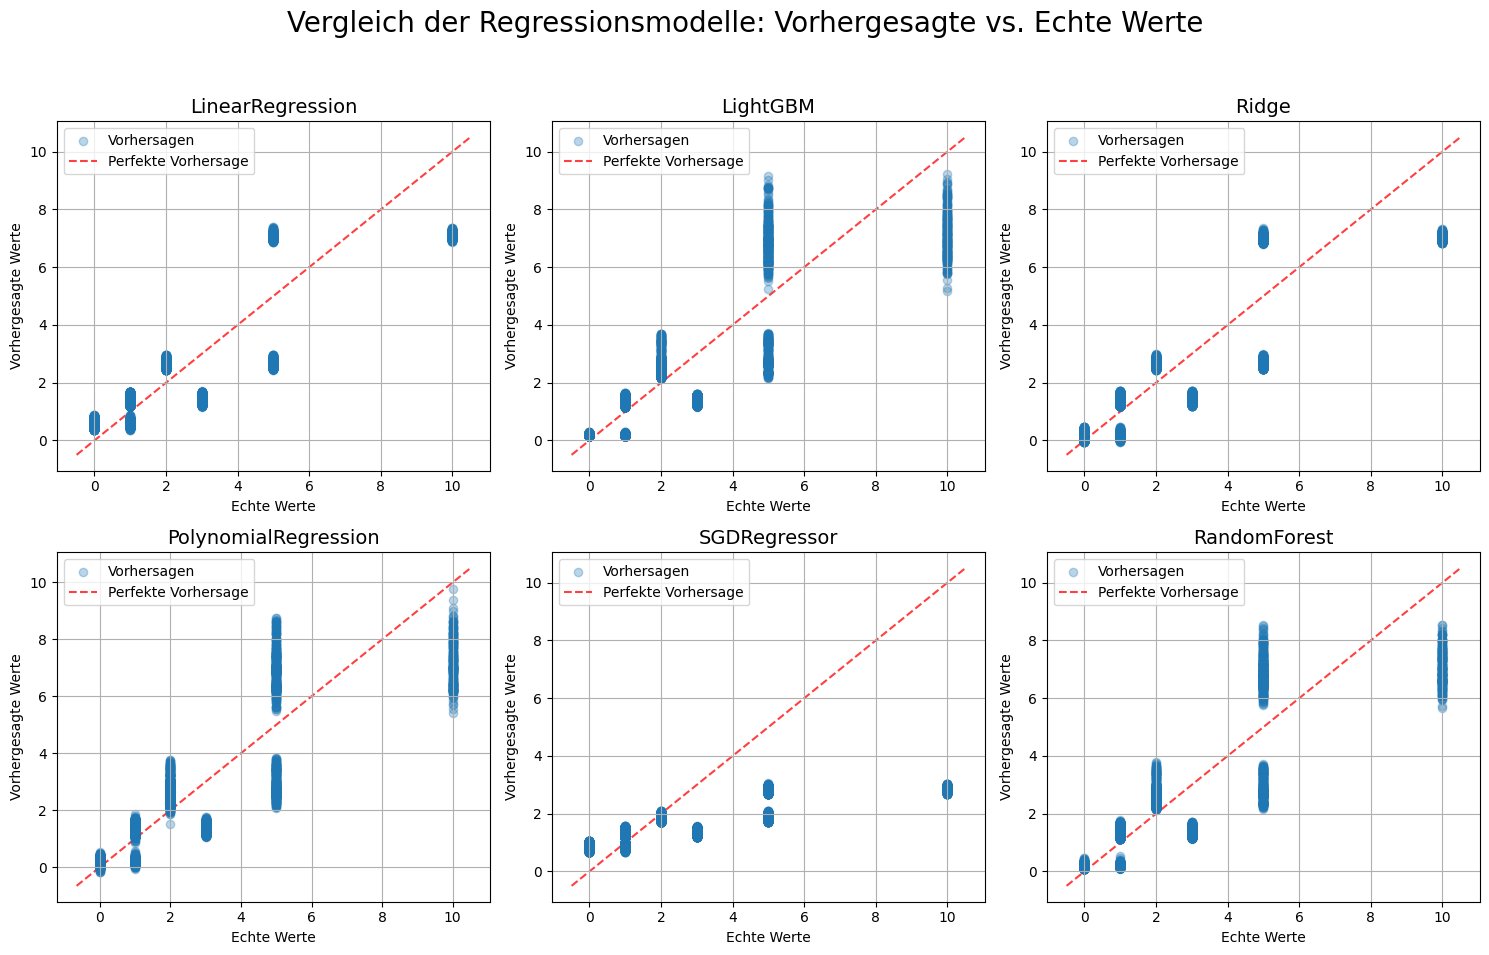

In [10]:
try:
   
    # Bestimme die Anzahl der Modelle für das Subplot-Gitter
    num_models = len(loaded_regression_models)
    # Erstelle ein Gitter, z.B. 2x3 für 6 Modelle
    nrows = (num_models + 2) // 3 
    ncols = 3
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))
    # 'axes.flatten()' macht die Handhabung einfacher, falls wir z.B. nur 1 Zeile haben
    axes = axes.flatten()

    fig.suptitle('Vergleich der Regressionsmodelle: Vorhergesagte vs. Echte Werte', fontsize=20)

    # Gehe durch jedes Modell und erstelle einen Subplot
    for i, (name, model) in enumerate(loaded_regression_models.items()):
        ax = axes[i]
        
        # Mache Vorhersagen auf dem Validierungs-Set
        y_pred = model.predict(X_val)
        
        # Zeichne die Punkte (Vorhersage vs. Echter Wert)
        ax.scatter(y_val, y_pred, alpha=0.3, label='Vorhersagen')
        
        # Zeichne die perfekte 45-Grad-Linie als Referenz
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # Finde den minimalen Wert
            np.max([ax.get_xlim(), ax.get_ylim()]),  # Finde den maximalen Wert
        ]
        ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfekte Vorhersage')
        
        ax.set_title(name, fontsize=14)
        ax.set_xlabel('Echte Werte')
        ax.set_ylabel('Vorhergesagte Werte')
        ax.legend()
        ax.grid(True)

    # Verstecke leere Subplots, falls die Anzahl der Modelle nicht perfekt ins Gitter passt
    for i in range(num_models, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Passt das Layout an den Haupttitel an
    plt.show()

except NameError as e:
    print(f"FEHLER: Stellen Sie sicher, dass 'df_Regression_featureSelection' und 'loaded_regression_models' korrekt geladen sind. ({e})")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

Dies ist eine Interpretation der Streudiagramme, die die **Vorhergesagten Werte** (Y-Achse) gegen die **Echten Werte** (X-Achse) für sechs verschiedene Regressionsmodelle vergleichen.

**Grundlegendes zur Interpretation:**

* **Rote gestrichelte Linie ("Perfekte Vorhersage"):** Diese Linie repräsentiert den Idealfall, bei dem die vorhergesagten Werte exakt den echten Werten entsprechen ($y = x$).
* **Blaue Punkte ("Vorhersagen"):** Jeder Punkt ist eine Vorhersage des Modells für einen echten Wert.
* **Ziel:** Die blauen Punkte sollten so **nah wie möglich** an der roten Linie liegen. Eine größere Streuung oder eine systematische Abweichung von der roten Linie deutet auf eine schlechtere Modellperformance hin.

### Gesamteindruck

Insgesamt zeigen alle Modelle eine **hohe Konzentration von Vorhersagen bei sehr niedrigen Werten** (im Bereich von 0 bis ca. 2 auf beiden Achsen). Dies könnte darauf hindeuten, dass der Datensatz viele niedrige Beobachtungen enthält und die Modelle diese relativ gut erfassen.

Die Performance der Modelle lässt im höheren Wertebereich (ab ca. 4) jedoch nach, was durch eine stärkere Streuung der Punkte und Abweichungen von der roten Linie erkennbar wird.

Basierend auf dieser visuellen Analyse liefern die **Ensemble-Methoden (`LightGBM` und `RandomForest`)** die besten Ergebnisse, da ihre Vorhersagen am engsten um die Linie der perfekten Vorhersage verteilt sind, was auf einen niedrigeren Vorhersagefehler hindeutet.

Die **`SGDRegressor`** hat die größten Probleme mit der Genauigkeit. Die klassischen linearen Modelle (`LinearRegression`, `Ridge`) liefern akzeptable, aber deutlich schlechtere Ergebnisse als die Ensemble-Methoden, insbesondere bei der Vorhersage größerer Werte.

Starte Ladevorgang der Regressionsmodelle...
  - 'LinearRegression' erfolgreich geladen.
  - 'LightGBM' erfolgreich geladen.
  - 'Ridge' erfolgreich geladen.
  - 'PolynomialRegression' erfolgreich geladen.
  - 'SGDRegressor' erfolgreich geladen.
  - 'RandomForest' erfolgreich geladen.


c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(


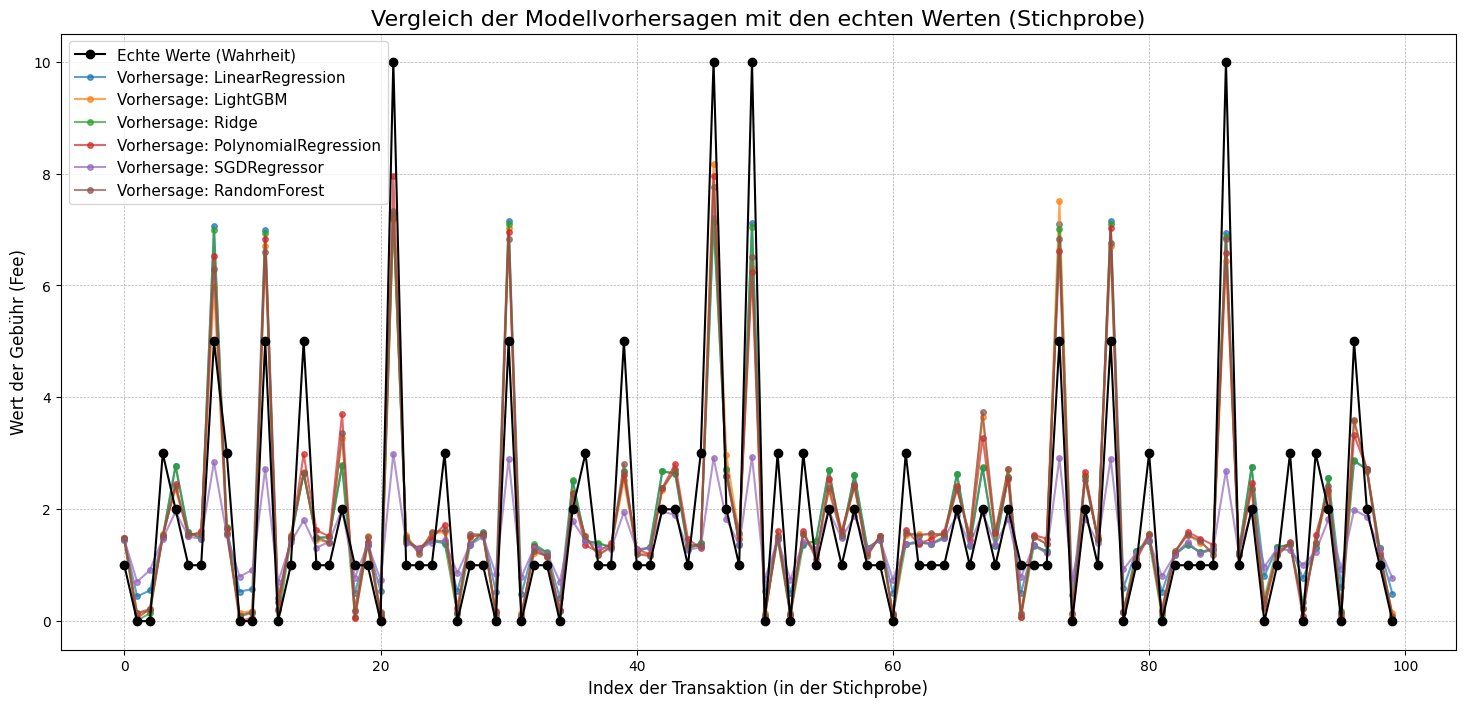

In [11]:
# 1. Zuordnung von einfachen Namen zu den Dateinamen aus Ihrer Liste
model_files = {
    "LinearRegression": "df_Regression_featureSelection_Regression_Baseline_e9dfbe96f0af4fd3aee0ba53513c9efe.pkl", #
    "LightGBM": "LightLBM_welcoming-goat-773_81615ca5c0ee4106a929281f6d45ef89.pkl", 
    "Ridge": "Ridge_lyrical-fish-906_701c422181374fc7a2aac1193eac61d5.pkl", 
    "PolynomialRegression": "PolynomialRegression_dashing-steed-178_bd98e67add2840c1b40eac80a6aa32ec.pkl", 
    "SGDRegressor": "sdgRegression_persistent-moth-983_79ee8f444b734a059a27d0e6ad283160.pkl", #
    "RandomForest": "RandomForestRegressor_stately-cat-164_376d2771b47a46719bc3596775b8e657.pkl" 
}

# 2. Ladevorgang
# Pfad zum Verzeichnis, in dem die Modelle liegen.
models_dir = Path.cwd()

# Leeres Dictionary, um die geladenen Modelle zu speichern
loaded_regression_models = {}

print("Starte Ladevorgang der Regressionsmodelle...")

# Gehe durch jedes Modell in unserer Liste
for name, filename in model_files.items():
    model_path = models_dir / filename
    try:
        with open(model_path, 'rb') as file:
            # Lade das Modell und füge es dem Dictionary hinzu
            loaded_regression_models[name] = pickle.load(file)
        print(f"  - '{name}' erfolgreich geladen.")
    except FileNotFoundError:
        print(f"  - FEHLER: Modell '{name}' wurde nicht gefunden unter: '{model_path}'")
    except Exception as e:
        print(f"  - FEHLER beim Laden von '{name}': {e}")
try:
    # --- PLOT ERSTELLEN ---
    
    # Wir nehmen eine Stichprobe der ersten 100 Datenpunkte für die Übersichtlichkeit
    num_samples_to_plot = 100
    # Stellen Sie sicher, dass X_val ein DataFrame ist, um Slicing zu ermöglichen
    X_sample = X_val[:num_samples_to_plot] if isinstance(X_val, pd.DataFrame) else pd.DataFrame(X_val)[:num_samples_to_plot]
    y_sample_true = y_val[:num_samples_to_plot]
    
    plt.figure(figsize=(18, 8))
    
    # 1. Zeichne die echten Werte als Referenz
    # .values wird verwendet, um sicherzustellen, dass wir mit einem Numpy-Array plotten
    plt.plot(y_sample_true.values if hasattr(y_sample_true, 'values') else y_sample_true, 
             'o-', color='black', label='Echte Werte (Wahrheit)', markersize=6, zorder=5)

    # 2. Gehe durch jedes Modell und zeichne seine Vorhersagen
    for name, model in loaded_regression_models.items():
        y_sample_pred = model.predict(X_sample)
        plt.plot(y_sample_pred, '.-', alpha=0.7, label=f'Vorhersage: {name}', markersize=8)

    # 3. Finalisiere den Plot
    plt.title('Vergleich der Modellvorhersagen mit den echten Werten (Stichprobe)', fontsize=16)
    plt.xlabel('Index der Transaktion (in der Stichprobe)', fontsize=12)
    plt.ylabel('Wert der Gebühr (Fee)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

except NameError as e:
    print(f"FEHLER: Stellen Sie sicher, dass 'X_val', 'y_val' und 'loaded_regression_models' korrekt geladen sind. ({e})")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

Dieses Diagramm ( eine Stichprobe) zeigt, dass beide Modelle – **LightGBM und RandomForest – dem Trend der echten Werte (Fee) gut folgen, die absolute Höhe der Spitzenwerte jedoch tendenziell deutlich unterschätzen.** LightGBM (blau) scheint in einigen Spitzenwerten (z. B. Index 30 und 75) etwas präzisere Schätzungen zu liefern als RandomForest (orange). Insgesamt liefern beide fortschrittlichen Modelle eine ähnliche und relativ gute Annäherung, jedoch mit klaren Einschränkungen bei extremen Transaktionsgebühren.

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(


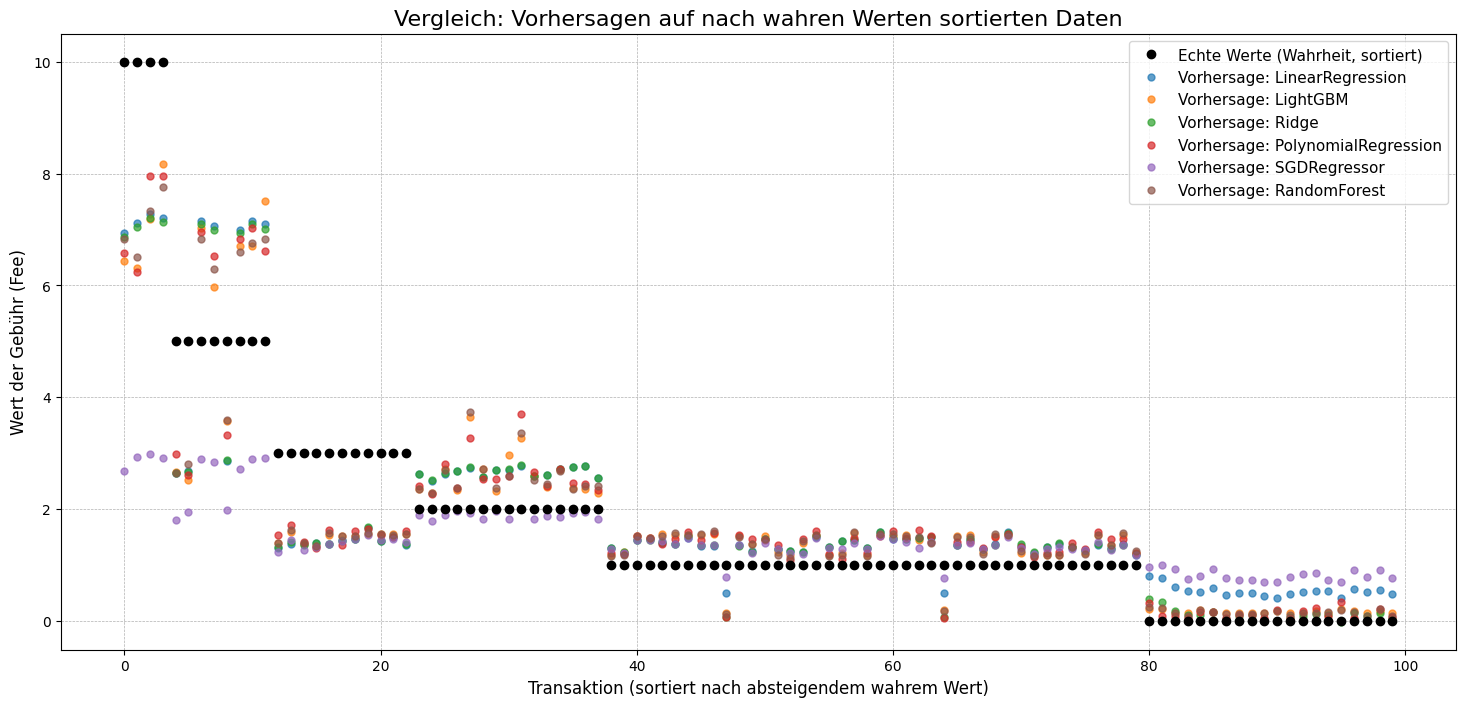

In [12]:
try:
    # --- PLOT ERSTELLEN ---
    
    # Wir nehmen eine Stichprobe der ersten 100 Datenpunkte für die Übersichtlichkeit
    num_samples_to_plot = 100
    X_sample = X_val[:num_samples_to_plot] if isinstance(X_val, pd.DataFrame) else pd.DataFrame(X_val)[:num_samples_to_plot]
    y_sample_true = y_val[:num_samples_to_plot]
    
    # --- Sortiere die Stichprobe nach dem wahren Wert ---
    sort_df = pd.DataFrame({
        'true_values': y_sample_true.values if hasattr(y_sample_true, 'values') else y_sample_true
    })
    sort_df = sort_df.sort_values(by='true_values', ascending=False)
    
    y_sorted = sort_df['true_values'].values
    X_sorted = X_sample.iloc[sort_df.index]
    x_axis = range(len(y_sorted))
    
    # --- PLOT ERSTELLEN MIT SORTIERTEN DATEN ALS PUNKTE ---
    plt.figure(figsize=(18, 8))
    
    # 1. Zeichne die SORTIERTEN echten Werte als Referenzpunkte
    # KORRIGIERT: 'o-' zu 'o' geändert, um nur Punkte zu zeichnen
    plt.plot(x_axis, y_sorted, 'o', color='black', label='Echte Werte (Wahrheit, sortiert)', markersize=6, zorder=5)

    # 2. Gehe durch jedes Modell und zeichne seine Vorhersagen als Punkte
    for name, model in loaded_regression_models.items():
        y_pred_sorted = model.predict(X_sorted)
        # KORRIGIERT: '.-' zu 'o' geändert und markersize angepasst für bessere Sichtbarkeit
        plt.plot(x_axis, y_pred_sorted, 'o', alpha=0.7, label=f'Vorhersage: {name}', markersize=5)

    # 3. Finalisiere den Plot
    plt.title('Vergleich: Vorhersagen auf nach wahren Werten sortierten Daten', fontsize=16)
    plt.xlabel('Transaktion (sortiert nach absteigendem wahrem Wert)', fontsize=12)
    plt.ylabel('Wert der Gebühr (Fee)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

except NameError as e:
    print(f"FEHLER: Stellen Sie sicher, dass 'X_val', 'y_val' und 'loaded_regression_models' korrekt geladen sind. ({e})")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

Die Unterschätzung von hohen Werten ist auch in diesem Diagramm gut zu beobachten.

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(


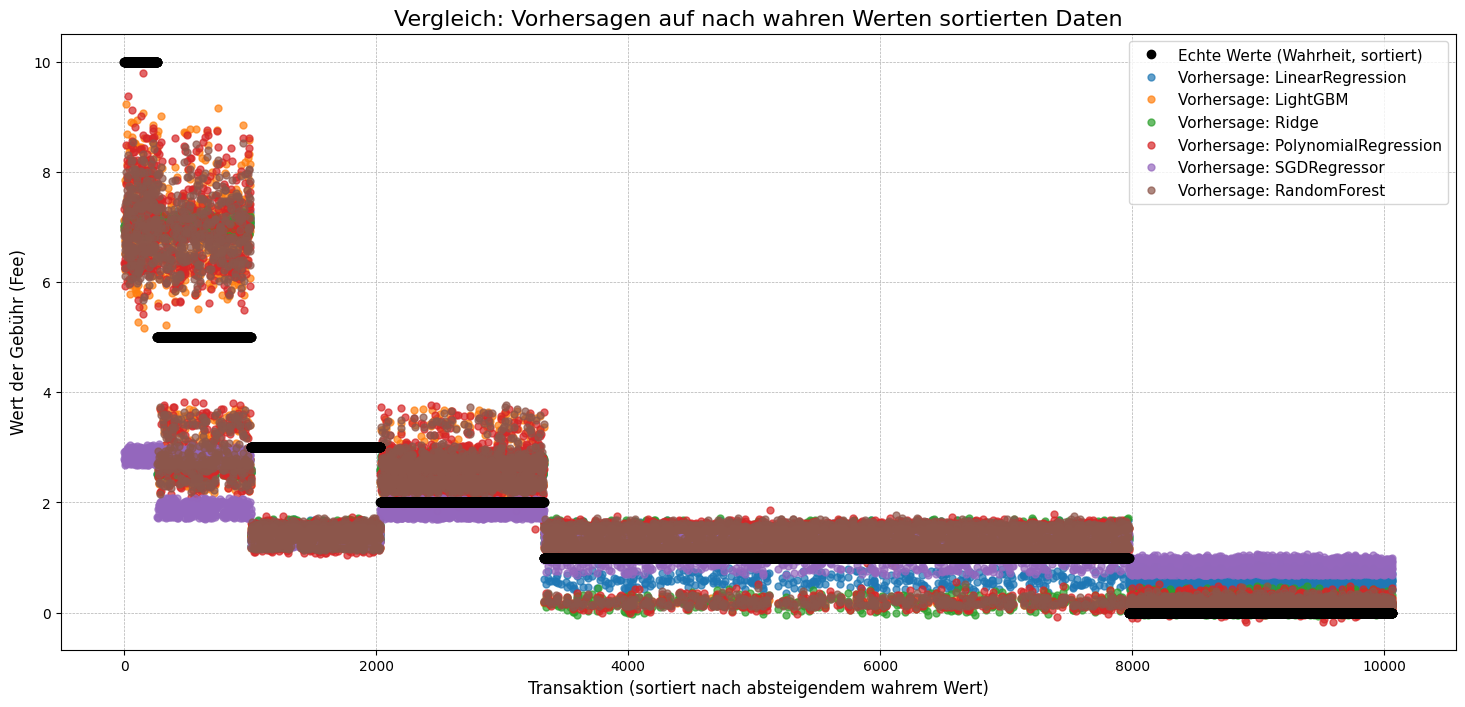

In [13]:
try:    
    # Wir nehmen eine Stichprobe der ersten 100 Datenpunkte für die Übersichtlichkeit
    num_samples_to_plot = 100
    X_sample = X_val[:num_samples_to_plot] if isinstance(X_val, pd.DataFrame) else pd.DataFrame(X_val)[:num_samples_to_plot]
    y_sample_true = y_val[:num_samples_to_plot]
    
    # --- Sortiere die Stichprobe nach dem wahren Wert ---
    sort_df = pd.DataFrame({
        'true_values': y_val.values if hasattr(y_val, 'values') else y_val
    })
    sort_df = sort_df.sort_values(by='true_values', ascending=False)
    
    y_sorted = sort_df['true_values'].values
    X_sorted = X_val.iloc[sort_df.index]
    x_axis = range(len(y_sorted))
    
    # --- PLOT ERSTELLEN MIT SORTIERTEN DATEN ALS PUNKTE ---
    plt.figure(figsize=(18, 8))
    
    # 1. Zeichne die SORTIERTEN echten Werte als Referenzpunkte
    # KORRIGIERT: 'o-' zu 'o' geändert, um nur Punkte zu zeichnen
    plt.plot(x_axis, y_sorted, 'o', color='black', label='Echte Werte (Wahrheit, sortiert)', markersize=6, zorder=5)

    # 2. Gehe durch jedes Modell und zeichne seine Vorhersagen als Punkte
    for name, model in loaded_regression_models.items():
        y_pred_sorted = model.predict(X_sorted)
        # KORRIGIERT: '.-' zu 'o' geändert und markersize angepasst für bessere Sichtbarkeit
        plt.plot(x_axis, y_pred_sorted, 'o', alpha=0.7, label=f'Vorhersage: {name}', markersize=5)

    # 3. Finalisiere den Plot
    plt.title('Vergleich: Vorhersagen auf nach wahren Werten sortierten Daten', fontsize=16)
    plt.xlabel('Transaktion (sortiert nach absteigendem wahrem Wert)', fontsize=12)
    plt.ylabel('Wert der Gebühr (Fee)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

except NameError as e:
    print(f"FEHLER: Stellen Sie sicher, dass 'X_val', 'y_val' und 'loaded_regression_models' korrekt geladen sind. ({e})")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

Auch dieses Diagramm visualisiert die **systematische Unterschätzung** hoher Gebühren durch beide Modelle. Die echten Gebührenwerte (Schwarz) sind in die Kosten Cluster unterteilt (z.B. $10, $5, $3, $2, $1, $0). Sowohl **LightGBM (Blau) als auch RandomForest (Orange)** versagen darin, die extrem hohen Werte ($10 und $5) präzise zu treffen und komprimieren die Vorhersagen stark nach unten. Bei den mittleren und niedrigen Werten ($3, $2, $1, $0) zeigen die Modelle zwar eine bessere Gruppierung, aber auch hier ist die Streuung beträchtlich, was insgesamt auf eine **eingeschränkte Fähigkeit** zur korrekten Vorhersage der Gebührenhöhe hindeutet. Das kann damit zusammenhängen, dass die hohenKosten bspw von Goldcard produzoert werden und es wesentlich weniger Goldcard Transaktionen gibt,als günstige PSP Anbieter Transaktionen.

# Nächste Schritte: Gezielte Bekämpfung der Unterschätzung hoher Werte

Nach der Analyse, die eine systematische Unterschätzung hoher Transaktionsgebühren (insbesondere des Werts 10) gezeigt hat, werden als Nächstes gezielte Maßnahmen zur Modellverbesserung durchgeführt:

1.  **Gezielte Gewichtung:** Die **LightGBM**-Modelloptimierung wird durch die Einführung von **Stichprobengewichten** (`sample_weights`) erweitert. Dies priorisiert Transaktionen mit kritischen, oft unterschätzten Zielwerten – hier **10.0 und 6.0** – um dem Modell beizubringen, diesen Fällen mehr Aufmerksamkeit zu schenken.

2.  **Erweiterte Hyperparameter-Optimierung:** Mithilfe von **Hyperopt** wird ein **erweitertes Optimierungsexperiment** durchgeführt. Der Suchraum umfasst nun nicht nur die üblichen LGBM-Hyperparameter (wie `n_estimators` und `learning_rate`), sondern auch die **Gewichtungsfaktoren** (`weight_for_10` und `weight_for_6`) selbst.

3.  **Automatisierte Gewichtssuche:** In jedem Durchlauf der Optimierung werden dynamisch neue Stichprobengewichte basierend auf den von Hyperopt vorgeschlagenen Faktoren erstellt und an die `LGBMRegressor.fit()`-Methode übergeben. Ziel ist es, die **optimale Kombination** aus Modellparametern und Gewichtung zu finden, die den validierten **RMSE** minimiert und gleichzeitig die Vorhersage der Spitzenwerte verbessert.

Dieser Ansatz soll die Einschränkungen der vorherigen ungewichteten Modelle überwinden und zu einem robusteren Regressionsmodell führen.


In [14]:
experiment_name = "Regression_value_around_10"

## Wert y=10 Fehler härter gewichtet

In [52]:
# Erstelle ein Array, in dem jede Transaktion initial das Gewicht 1 hat
sample_weights = np.ones(len(y_train))

# Setze das Gewicht für alle Trainings-Transaktionen, deren wahre Gebühr 10.0 ist, auf einen höheren Wert
# Der Faktor (hier 10.0) kann angepasst werden, um die Priorisierung zu steuern.
weight_factor = 5.0 
sample_weights[y_train == 10.0] = weight_factor

print(f"Stichprobengewichte erstellt. {np.sum(y_train == 10.0)} Proben mit Zielwert 10.0 wurden höher gewichtet.")

# === SUCHRAUM (unverändert) ===
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'max_depth': hp.quniform('max_depth', 5, 20, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 100, 5),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
}

# === TRAININGS- UND EVALUIERUNGSFUNKTION (ANGEPASST) ===
def train_eval_lgbm(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['num_leaves'] = int(params['num_leaves'])
    
    model = lgb.LGBMRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)
    
    # --- HINZUGEFÜGT: 'sample_weight' wird an die fit-Methode übergeben ---
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(50, verbose=False)],
              sample_weight=sample_weights) # <--- HIER

    pred_tr = model.predict(X_train)
    pred_te = model.predict(X_val)

    m_tr = compute_regression_metrics(y_train, pred_tr, prefix="train_")
    m_te = compute_regression_metrics(y_val, pred_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    
    return model, metrics

# === OBJECTIVE-FUNKTION und EXPERIMENT-AUSFÜHRUNG bleiben unverändert ===
# (Sie rufen die angepasste train_eval_lgbm Funktion auf)

def objective_lgbm(params):
    with mlflow.start_run(nested=True):
        # ... (Funktion bleibt unverändert)
        mlflow.log_param("Model", "LGBMRegressor_Weighted") # Name angepasst
        mlflow.log_param("metric", "rmse")
        mlflow.log_params(params)
        model, metrics = train_eval_lgbm(params)
        mlflow.log_metrics(metrics)
        mlflow.log_metric("best_iteration", model.best_iteration_)
        sig = infer_signature(X_train, model.predict(X_train))
        mlflow.lightgbm.log_model(model, "model", signature=sig)
        return {"loss": metrics["val_rmse"], "status": STATUS_OK}

def run_hyperopt_lgbm():
    # ... (Funktion bleibt unverändert)
    mlflow.set_experiment(experiment_name)
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)
    with mlflow.start_run(run_name="lgbm-hyperopt-rmse-weighted") as parent: # Name angepasst
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS, "metric": "rmse"})
        best = fmin(fn=objective_lgbm, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        best_loss = trials.best_trial['result']['loss']
        mlflow.log_metrics({"best_val_rmse": best_loss})
        best_params = space_eval(space, best)
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        print("\nBester gefundener Run:")
        print(f"Bester RMSE: {best_loss:.4f}")
        print("Beste Parameter:", best_params)
    return best_params, best_loss

# === AUSFÜHRUNG ===
best_params_lgbm_w, best_rmse_lgbm_w = run_hyperopt_lgbm()

Stichprobengewichte erstellt. 1042 Proben mit Zielwert 10.0 wurden höher gewichtet.
  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000937 seconds
INFO:hyperopt.tpe:TPE using 0 trials


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                      
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565  
🏃 View run able-dove-242 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/2a7fb9e89e9445969c7f1138433d312b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

  2%|▎         | 1/40 [00:05<03:23,  5.23s/trial, best loss: 1.016]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001013 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.016000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565               
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001996 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.016000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565               
🏃 View run industrious-cub-349 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/84528846dbf346759737c471d1b25fa5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

  8%|▊         | 3/40 [00:16<03:17,  5.32s/trial, best loss: 1.016]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.016000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565               
🏃 View run rebellious-pug-247 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/9fd2e881094d4690934b80b846f374e8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 10%|█         | 4/40 [00:21<03:13,  5.37s/trial, best loss: 1.016]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001884 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.016000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565               
🏃 View run rebellious-tern-603 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/a7d36965aa274be3b6a3b7a52345ee0c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 12%|█▎        | 5/40 [00:26<03:06,  5.32s/trial, best loss: 1.016]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002046 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.016000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565               
🏃 View run colorful-bird-903 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/79f6412b988544a794d1350681c3ac33

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 15%|█▌        | 6/40 [00:32<02:59,  5.29s/trial, best loss: 1.016]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001054 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.016000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565               
🏃 View run sincere-mouse-586 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/4280943bd8814da2aa24cd9318e9b5d5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 18%|█▊        | 7/40 [00:37<02:54,  5.30s/trial, best loss: 1.016]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.016000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565               
🏃 View run resilient-midge-490 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/cba058910cec4302902dd353a7ac28e0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 20%|██        | 8/40 [00:43<02:53,  5.42s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001072 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565               
🏃 View run delicate-koi-537 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/2b2ea40863514d02b7d952748162834f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 22%|██▎       | 9/40 [00:48<02:44,  5.30s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002004 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565               
🏃 View run resilient-gnu-365 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/08ad292dadbd4114b07b5c7d68573164

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 25%|██▌       | 10/40 [00:53<02:38,  5.27s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run learned-rook-356 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/25d8dc662b5348eda361654b404edf3e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 28%|██▊       | 11/40 [00:58<02:31,  5.22s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run amusing-penguin-643 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/70ec5ad6f675481da9b966f38c3cd998

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 30%|███       | 12/40 [01:03<02:27,  5.27s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run nosy-frog-410 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/ccc9a62195194136bc1e00973e61de17

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 35%|███▌      | 14/40 [01:13<02:13,  5.14s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run adventurous-yak-150 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/5a859a19543b48f5a869b53cb93063a8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 38%|███▊      | 15/40 [01:19<02:09,  5.19s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001996 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001884 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run classy-koi-783 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/ab4f78dc43b442febedb132b767e37c1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 42%|████▎     | 17/40 [01:29<02:00,  5.25s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000930 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run painted-sloth-406 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/9bcc6fea3acd4c749fd52b087e04f462

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 45%|████▌     | 18/40 [01:35<01:57,  5.34s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000971 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run amusing-mare-984 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/2b9b69f1fe774eff8472475b1be9cae4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 48%|████▊     | 19/40 [01:41<01:58,  5.65s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run kindly-grub-833 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/3981dc4a906c48b9856e513dcf576b3e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 50%|█████     | 20/40 [01:47<01:51,  5.59s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run masked-quail-459 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/a7f46323b8874d6ea4fd4a0c38b68e61

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 52%|█████▎    | 21/40 [01:52<01:44,  5.49s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000992 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run skittish-fowl-396 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/65e25e0918e149ecbec79c09a639e33e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 55%|█████▌    | 22/40 [01:57<01:37,  5.42s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001012 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run traveling-fox-567 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/52f28b10f85b493d9b3d0cb647f3e7b7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 57%|█████▊    | 23/40 [02:03<01:32,  5.47s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001995 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000967 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
🏃 View run learned-yak-297 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/f69ae7343f1d48ffaa102f7a00aa13fc

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 62%|██████▎   | 25/40 [02:15<01:25,  5.67s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run gentle-quail-85 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/07b25d8b73e947528a69509f3f44ebfd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 65%|██████▌   | 26/40 [02:20<01:17,  5.55s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001994 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run casual-colt-130 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/aa899bb7a397429cb75263ba74e09c3f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 70%|███████   | 28/40 [02:32<01:08,  5.73s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001003 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run big-skink-400 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/ada53f437a3a42c88f429d9cb75991e7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 72%|███████▎  | 29/40 [02:38<01:04,  5.89s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run enthused-gull-197 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/c1771f98d1fd409fa86d7ca523c660e3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 78%|███████▊  | 31/40 [02:50<00:53,  5.98s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run gregarious-gull-641 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/12f1c504fec546f69c9b76f97eafb383

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 80%|████████  | 32/40 [02:56<00:47,  5.92s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001917 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001992 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run caring-stoat-504 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/38616434622741f7bf52e74f7c1b30f9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 85%|████████▌ | 34/40 [03:07<00:34,  5.69s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002007 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run resilient-quail-446 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/f9f10ebb7e97413488610e1a796720ee

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 88%|████████▊ | 35/40 [03:13<00:28,  5.72s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002014 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run blushing-bear-734 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/f6fd81fd359443bba703296486ed16df

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 90%|█████████ | 36/40 [03:18<00:22,  5.71s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run aged-eel-0 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/350e883103c8479b92bef787b2b057fa

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 92%|█████████▎| 37/40 [03:24<00:16,  5.59s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run sneaky-shrimp-993 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/8fc70b310d8e43b2812f47bff6a90eb0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 95%|█████████▌| 38/40 [03:29<00:10,  5.46s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run casual-gnu-271 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/4571905d1fcf4c3181ab7bd1e5842218

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 98%|█████████▊| 39/40 [03:35<00:05,  5.59s/trial, best loss: 1.015]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000912 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss 1.015000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.436565                
🏃 View run overjoyed-seal-603 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/c24bf7b36d5345dfbe39b484d7e21641

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

100%|██████████| 40/40 [03:40<00:00,  5.52s/trial, best loss: 1.015]

Bester gefundener Run:
Bester RMSE: 1.0150
Beste Parameter: {'colsample_bytree': 0.9212745246023865, 'learning_rate': 0.01520187687599419, 'max_depth': 10.0, 'n_estimators': 750.0, 'num_leaves': 85.0, 'subsample': 0.7192860589928647}
🏃 View run lgbm-hyperopt-rmse-wei

## Wert y=10 und y=6 Fehler schwerer gewichtet + Hyperpot der Gewichtungen

In [53]:
# === ERWEITERTER SUCHRAUM: Inklusive Sample Weights ===
space = {
    # Bisherige LGBM-Parameter, jetzt in einem eigenen Dictionary verschachtelt
    'lgbm_params': {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'max_depth': hp.quniform('max_depth', 5, 20, 1),
        'num_leaves': hp.quniform('num_leaves', 20, 100, 5),
        'subsample': hp.uniform('subsample', 0.7, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
    },
    # HINZUGEFÜGT: Parameter für die Stichprobengewichtung
    'sample_weights': {
        'weight_for_10': hp.uniform('weight_for_10', 1, 10), # Teste Gewichte zwischen 1 (kein Effekt) und 10
        'weight_for_6': hp.uniform('weight_for_6', 1, 10)
    }
}

# === ANGEPASSTE TRAININGSFUNKTION: Akzeptiert Sample Weights ===
def train_eval_lgbm(params, custom_sample_weights): # Nimmt jetzt Gewichte als Argument
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['num_leaves'] = int(params['num_leaves'])
    
    model = lgb.LGBMRegressor(**params, random_state=RANDOM_STATE, n_jobs=-1)
    
    # Verwendet die übergebenen, für jeden Run spezifischen Gewichte
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(50, verbose=False)],
              sample_weight=custom_sample_weights) # <--- HIER

    # Der Rest bleibt gleich...
    pred_tr = model.predict(X_train)
    pred_te = model.predict(X_val)
    m_tr = compute_regression_metrics(y_train, pred_tr, prefix="train_")
    m_te = compute_regression_metrics(y_val, pred_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    return model, metrics

# === ANGEPASSTE OBJECTIVE-FUNKTION: Erstellt Sample Weights bei jedem Durchlauf ===
def objective_lgbm_weighted(params):
    with mlflow.start_run(nested=True):
        # Entpacke die verschachtelten Parameter
        lgbm_params = params['lgbm_params']
        weight_params = params['sample_weights']
        
        mlflow.log_param("Model", "LGBMRegressor_WeightedTuning")
        mlflow.log_param("metric", "rmse")
        mlflow.log_params(lgbm_params)
        mlflow.log_params(weight_params) # Logge auch die getesteten Gewichte
        
        # Erstelle das Sample-Weight-Array für diesen spezifischen Durchlauf
        sample_weights = np.ones(len(y_train))
        sample_weights[y_train == 10] = weight_params['weight_for_10']
        sample_weights[y_train == 6] = weight_params['weight_for_6']
        
        # Rufe die Trainingsfunktion mit den Parametern UND den Gewichten auf
        model, metrics = train_eval_lgbm(lgbm_params, sample_weights)
        
        mlflow.log_metrics(metrics)
        mlflow.log_metric("best_iteration", model.best_iteration_)
        
        sig = infer_signature(X_train, model.predict(X_train))
        mlflow.lightgbm.log_model(model, "model", signature=sig)
        
        return {"loss": metrics["val_rmse"], "status": STATUS_OK}

# # === EXPERIMENT AUSFÜHREN (ruft die neue Objective-Funktion auf) ===
def run_hyperopt_lgbm_weighted():
    mlflow.set_experiment(experiment_name)
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    with mlflow.start_run(run_name="lgbm-hyperopt-rmse-dynamic-weights") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS, "metric": "rmse"})
        
        best = fmin(fn=objective_lgbm_weighted, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        
        best_loss = trials.best_trial['result']['loss']
        mlflow.log_metrics({"best_val_rmse": best_loss})

        best_params = space_eval(space, best)
        # Logge die besten Parameter getrennt für bessere Übersicht
        mlflow.log_params({f"best_lgbm_{k}": v for k, v in best_params['lgbm_params'].items()})
        mlflow.log_params({f"best_weights_{k}": v for k, v in best_params['sample_weights'].items()})
        
        print("\nBester gefundener Run:")
        print(f"Bester RMSE: {best_loss:.4f}")
        print("Beste Parameter:", best_params)

    return best_params, best_loss

# === AUSFÜHRUNG ===
best_params_w, best_rmse_w = run_hyperopt_lgbm_weighted()

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002048 seconds
INFO:hyperopt.tpe:TPE using 0 trials


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                      
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.706985  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002966 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.036000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.689324               
🏃 View run bustling-lynx-961 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/9b2693019e6549748785506db625bdd4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

  5%|▌         | 2/40 [00:10<03:24,  5.39s/trial, best loss: 1.036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001251 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.036000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.794386               
🏃 View run adorable-seal-827 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/d35075e02d2a44f487746c6652ebbdc8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

  8%|▊         | 3/40 [00:15<03:12,  5.19s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.046727               
🏃 View run salty-snake-250 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/ffec168cfea94b0d9863eb50ab7ea4b3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 10%|█         | 4/40 [00:21<03:09,  5.28s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002026 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.837347               
🏃 View run powerful-fox-151 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/7a8ad8526b414d5eb1d09f1b72d32e0a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 12%|█▎        | 5/40 [00:26<03:03,  5.25s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001941 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.955322               
🏃 View run resilient-duck-43 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/d59ea87b3bdf4abcab044dea0fd6ba1f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 15%|█▌        | 6/40 [00:31<02:58,  5.25s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001994 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 3.226519               
🏃 View run sneaky-skink-390 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/00b87ccdb6d14adbb4d96365dbf08b24

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 18%|█▊        | 7/40 [00:37<03:00,  5.46s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001041 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 3.005871               
🏃 View run debonair-snail-353 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/d4d291ba985b479580e8c6cf7da97b3b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 20%|██        | 8/40 [00:43<03:03,  5.73s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002101 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.924797               
🏃 View run classy-wolf-994 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/f46fd4f1c78149df9cc045d12e781aad

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 22%|██▎       | 9/40 [00:49<02:57,  5.73s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.493779               
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
🏃 View run delightful-bat-78 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/87c5ac2fbf9b4080b635bbb964262b0d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 25%|██▌       | 10/40 [00:55<02:53,  5.79s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.733050                
🏃 View run worried-grub-328 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/56e0ae48fd664fd5a052a33bddec2c0d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 28%|██▊       | 11/40 [01:00<02:42,  5.61s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002030 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.689180                
🏃 View run marvelous-skunk-638 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/cbb3e1c92ed34630ae7a812be1288857

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 30%|███       | 12/40 [01:05<02:32,  5.44s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002982 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.866569                
🏃 View run unequaled-steed-461 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/423d276f99d8434fa8f90d8b9be619e6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 32%|███▎      | 13/40 [01:10<02:24,  5.36s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000983 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.472637                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
🏃 View run rambunctious-auk-769 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/d90a52ebcc12496b906eb2d6dc5457d9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 35%|███▌      | 14/40 [01:16<02:18,  5.33s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003121 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 3.107629                
🏃 View run casual-quail-244 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/91d97967ce294dd9bdc24093128543e5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 38%|███▊      | 15/40 [01:21<02:12,  5.29s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000995 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 3.214655                
🏃 View run lyrical-seal-304 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/9b2db53f6c234d0e917934e7861f117e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 40%|████      | 16/40 [01:26<02:07,  5.31s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002946 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.983952                
🏃 View run judicious-midge-400 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/4acb46e0cc4842228446ac3af4bed583

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 42%|████▎     | 17/40 [01:32<02:07,  5.53s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002329 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.849299                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001019 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 3.032749                
🏃 View run rogue-panda-184 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/18eadb1e75bd4c7994c10cc5015469bc

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 48%|████▊     | 19/40 [01:44<01:59,  5.70s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001890 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.842354                
🏃 View run lyrical-whale-481 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/1adf35ad660d4ed294aa3ca482dca6a3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 50%|█████     | 20/40 [01:50<01:51,  5.57s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001155 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.192991                
🏃 View run suave-gull-345 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/56987998bbf040628efa0baf88789667

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 52%|█████▎    | 21/40 [01:55<01:44,  5.48s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002993 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.316427                
🏃 View run bittersweet-colt-202 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/724c9f9a1a9145518b8708e83056353e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 55%|█████▌    | 22/40 [02:00<01:38,  5.48s/trial, best loss: 0.981]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002545 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss 0.981000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.707631                
🏃 View run grandiose-toad-549 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/a624a64161824ffa85824ec298be9860

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 57%|█████▊    | 23/40 [02:06<01:32,  5.43s/trial, best loss: 0.98] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001104 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss 0.980000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.121828               
🏃 View run industrious-vole-344 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/6d63afb37f244ae9af3e466b41e28881

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 60%|██████    | 24/40 [02:11<01:26,  5.42s/trial, best loss: 0.98]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001928 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss 0.980000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                   
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.675178               
🏃 View run traveling-pig-30 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/df4d9e7969e2426a9608bc29048cfd5c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 62%|██████▎   | 25/40 [02:16<01:19,  5.32s/trial, best loss: 0.979]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss 0.979000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.679447                
🏃 View run sneaky-hare-289 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/1a21f86d629f454396634db181a5232c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 65%|██████▌   | 26/40 [02:21<01:13,  5.27s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002034 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.298474                
🏃 View run amusing-cat-324 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/d58c349bf1ae4555beb611e402550960

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 68%|██████▊   | 27/40 [02:26<01:07,  5.18s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002903 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.657967                
🏃 View run painted-bug-946 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/18e82b113d3d48dd8a93f962a5e1adb0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 70%|███████   | 28/40 [02:31<01:02,  5.17s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002668 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.949707                
🏃 View run amazing-hare-824 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/cbb6a2df0904467196971a61703b6688

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 72%|███████▎  | 29/40 [02:36<00:56,  5.13s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002989 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.333365                
🏃 View run legendary-colt-186 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/c0318538b1524c4b80db7f90e8fd5806

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 75%|███████▌  | 30/40 [02:42<00:51,  5.20s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000884 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.616118                
🏃 View run loud-moose-745 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/21b96cf93cec4c7fbcc783b01e9d1b8b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 78%|███████▊  | 31/40 [02:48<00:48,  5.39s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002706 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.664046                
🏃 View run thoughtful-skunk-112 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/47df36bdfdc946c0bb738692533364b6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 80%|████████  | 32/40 [02:54<00:45,  5.64s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002553 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.982408                
🏃 View run funny-yak-301 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/0dd2e3d7bafb450590f89d4afcf9897e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 82%|████████▎ | 33/40 [03:01<00:42,  6.03s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003048 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.181731                
🏃 View run charming-carp-179 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/eeeead6b4fa84875ac7911ef375af23a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 85%|████████▌ | 34/40 [03:08<00:37,  6.33s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002504 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.901275                
🏃 View run adaptable-deer-144 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/fd740199af1b446da47af20161771279

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 88%|████████▊ | 35/40 [03:14<00:32,  6.41s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.097465                
🏃 View run selective-doe-791 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/e183ead9b41a472ab9f46bb40c0e642b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 90%|█████████ | 36/40 [03:21<00:25,  6.33s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.398795                
🏃 View run clean-whale-441 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/6e35b88a16fe463392a259dbdf90ef85

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 92%|█████████▎| 37/40 [03:27<00:19,  6.45s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.792561                
🏃 View run debonair-foal-686 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/6d365c4b200f4f6dba9e701ef92ceb17

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 95%|█████████▌| 38/40 [03:34<00:12,  6.43s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003007 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 2.032559                
🏃 View run amazing-colt-296 at: http://127.0.0.1:8080/#/experiments/323437426560080448/runs/40695ad4296f4494870b3ed9fc454897

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/323437426560080448

 98%|█████████▊| 39/40 [03:41<00:06,  6.72s/trial, best loss: 0.978]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004016 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss 0.978000


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297                                    
[LightGBM] [Info] Number of data points in the train set: 40263, number of used features: 13
[LightGBM] [Info] Start training from score 1.773544                
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

# Modell betrachten

In [15]:
model_files = {
    "LightGBM_value10_8": "lgbm_industrious-auk-547_c64674f0af0143bdb2d607ffdf9e32a6.pkl",
    "LightGBM_value10": "lgbm10_crawling-boar-12_d1ad86285a0b4868868f300261aa4364.pkl",
    "LightGBM": "LightLBM_welcoming-goat-773_81615ca5c0ee4106a929281f6d45ef89.pkl", 

}

# 2. Ladevorgang
# Pfad zum Verzeichnis, in dem die Modelle liegen.
models_dir = Path.cwd()


# Leeres Dictionary, um die geladenen Modelle zu speichern
loaded_regression_models = {}

print("Starte Ladevorgang der Regressionsmodelle...")

# Gehe durch jedes Modell in unserer Liste
for name, filename in model_files.items():
    model_path = models_dir / filename
    try:
        with open(model_path, 'rb') as file:
            # Lade das Modell und füge es dem Dictionary hinzu
            loaded_regression_models[name] = pickle.load(file)
        print(f"  - '{name}' erfolgreich geladen.")
    except FileNotFoundError:
        print(f"  - FEHLER: Modell '{name}' wurde nicht gefunden unter: '{model_path}'")
    except Exception as e:
        print(f"  - FEHLER beim Laden von '{name}': {e}")


Starte Ladevorgang der Regressionsmodelle...
  - 'LightGBM_value10_8' erfolgreich geladen.
  - 'LightGBM_value10' erfolgreich geladen.
  - 'LightGBM' erfolgreich geladen.


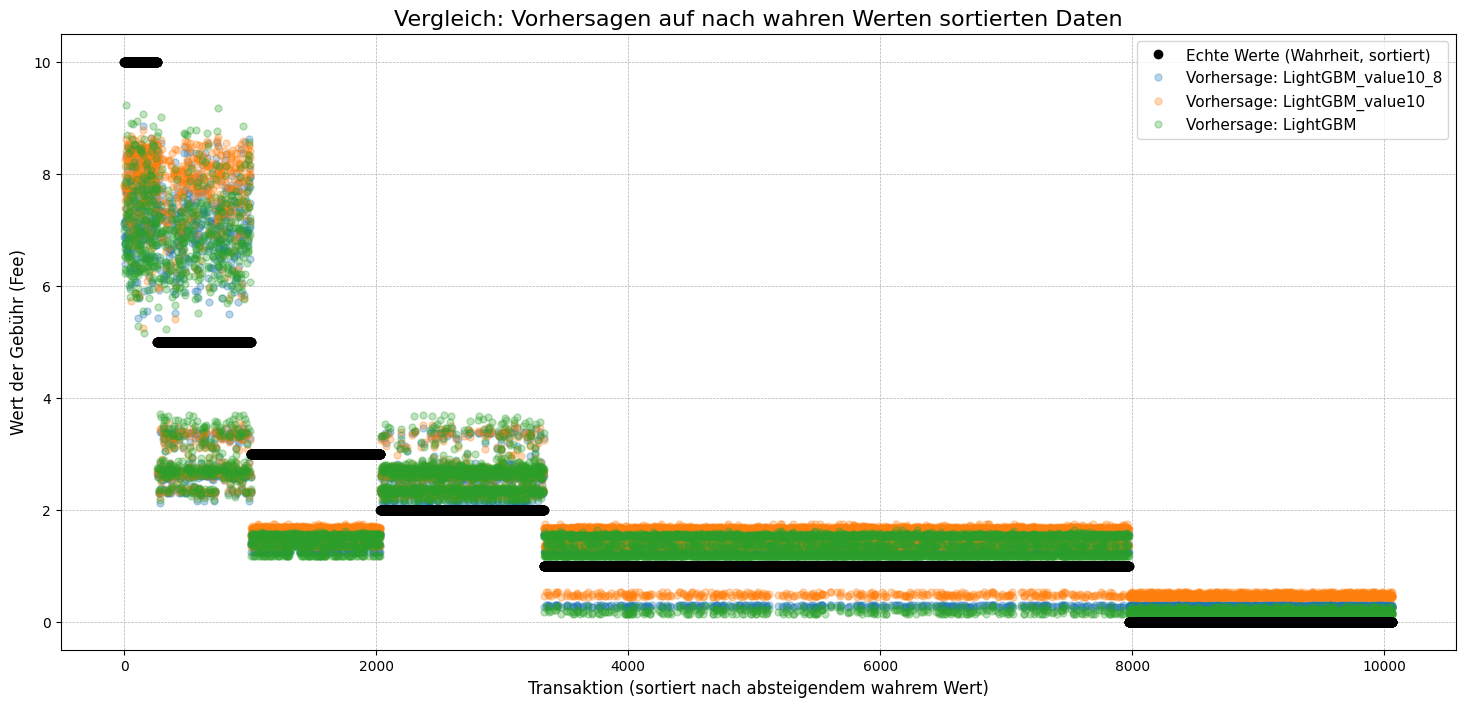

In [18]:
try:
    # (Dieser Teil bleibt unverändert)
    sort_df = pd.DataFrame({
        'true_values': y_val.values if hasattr(y_val, 'values') else y_val
    })
    sort_df = sort_df.sort_values(by='true_values', ascending=False)
    
    y_sorted = sort_df['true_values'].values
    X_sorted = X_val.iloc[sort_df.index]
    x_axis = range(len(y_sorted))
    
    # --- PLOT ERSTELLEN MIT SORTIERTEN DATEN ALS PUNKTE ---
    plt.figure(figsize=(18, 8))
    
    # 1. Zeichne die SORTIERTEN echten Werte als Referenzpunkte
    # HINZUGEFÜGT: alpha=0.7 für die schwarzen Punkte
    plt.plot(x_axis, y_sorted, 'o', color='black', label='Echte Werte (Wahrheit, sortiert)', markersize=6, zorder=5)

    # 2. Gehe durch jedes Modell und zeichne seine Vorhersagen als Punkte
    for name, model in loaded_regression_models.items():
        y_pred_sorted = model.predict(X_sorted)
        # Hier war alpha=0.7 bereits korrekt gesetzt
        plt.plot(x_axis, y_pred_sorted, 'o', alpha=0.3, label=f'Vorhersage: {name}', markersize=5)

    # 3. Finalisiere den Plot
    plt.title('Vergleich: Vorhersagen auf nach wahren Werten sortierten Daten', fontsize=16)
    plt.xlabel('Transaktion (sortiert nach absteigendem wahrem Wert)', fontsize=12)
    plt.ylabel('Wert der Gebühr (Fee)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

except NameError as e:
    print(f"FEHLER: Stellen Sie sicher, dass 'X_val', 'y_val' und 'loaded_regression_models' korrekt geladen sind. ({e})")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

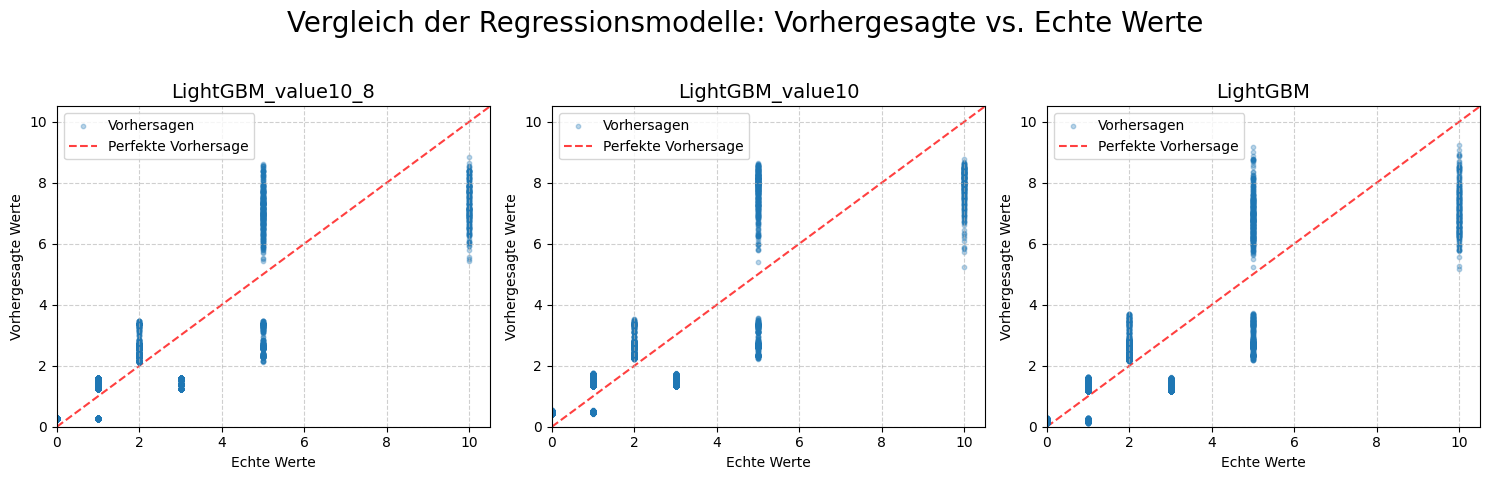

In [ ]:
try:
    
    # Bestimme die Anzahl der Modelle für das Subplot-Gitter
    num_models = len(loaded_regression_models)
    
    # Erstelle ein Gitter, z.B. 2x3 für 5 oder 6 Modelle
    # Berechnet die benötigten Zeilen automatisch
    ncols = 3 
    nrows = int(np.ceil(num_models / ncols))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 5))
    
    # 'axes.flatten()' macht die Handhabung einfacher
    axes = axes.flatten()

    fig.suptitle('Vergleich der Regressionsmodelle: Vorhergesagte vs. Echte Werte', fontsize=20)

    # Gehe durch jedes Modell und erstelle einen Subplot
    for i, (name, model) in enumerate(loaded_regression_models.items()):
        ax = axes[i]
        
        # Mache Vorhersagen auf dem Validierungs-Set
        y_pred = model.predict(X_val)
        
        # Zeichne die Punkte (Vorhersage vs. Echter Wert)
        # alpha=0.3 ist gut bei vielen Datenpunkten
        ax.scatter(y_val, y_pred, alpha=0.3, label='Vorhersagen', s=10) # s=10 für kleinere Punkte
        
        # Zeichne die perfekte 45-Grad-Linie als Referenz
        # Finde gemeinsame Limits für x und y, damit die Linie korrekt aussieht
        min_val = np.min([np.min(y_val), np.min(y_pred)]) * 0.95
        max_val = np.max([np.max(y_val), np.max(y_pred)]) * 1.05
        lims = [min_val, max_val]
        
        ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfekte Vorhersage')
        
        # Setze die Achsen auf dieselben Limits
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        
        ax.set_title(name, fontsize=14)
        ax.set_xlabel('Echte Werte')
        ax.set_ylabel('Vorhergesagte Werte')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    # Verstecke leere Subplots, falls die Anzahl der Modelle nicht perfekt ins Gitter passt
    for i in range(num_models, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Passt das Layout an den Haupttitel an
    plt.show()

except NameError as e:
    # Angepasst, um die tatsächlich verwendeten Variablen zu nennen
    print(f"FEHLER: Stellen Sie sicher, dass 'X_val', 'y_val' und 'loaded_regression_models' korrekt geladen sind. ({e})")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

Dieses Diagramm vergleicht die ursprüngliche LightGBM-Basislinie (Grün) mit zwei gewichteten LightGBM-Varianten (Blau/Orange). Die Gewichtung von höheren Werten scheint die Vorhersagen für die höchsten echten Werte ($10$ und $5$) **deutlich nach oben zu verschieben**, was die Unterschätzung reduziert. Allerdings führt diese Priorisierung auch zu einer **größeren Streuung und Ungenauigkeit** bei den niedrigeren Gebührenwerten ($1,5$ bis $0$), wo die Vorhersagen nun stark über das Ziel hinausschießen. Die Basislinie (Grün) bleibt bei den niedrigen Werten präziser, bestätigt aber weiterhin die starke Unterschätzung der Spitzenwerte. Die Ergebnisse sind alle nicht 100% zufriedenstellend, aber da hohe Werte vermieden werden sollen, wird trotzdem das Modell LightLBM_value10 präferiert.

In [56]:
try:
    # Finde die einzigartigen, tatsächlichen Gebührenwerte im Validierungsset
    unique_y_values = sorted(np.unique(y_val))
    
    # Erstelle einen leeren DataFrame, um die Ergebnisse zu speichern
    # Die Zeilen sind die echten Gebührenwerte, die Spalten sind die Modelle
    rmse_results_df = pd.DataFrame(index=unique_y_values, columns=loaded_regression_models.keys())
    rmse_results_df.index.name = "Echter Gebührenwert"

    # Gehe durch jedes Modell
    for name, model in loaded_regression_models.items():
        # Mache eine Vorhersage für das gesamte Validierungsset
        y_pred = model.predict(X_val)
        
        # Erstelle einen temporären DataFrame für einfaches Filtern
        temp_df = pd.DataFrame({'true': y_val, 'pred': y_pred})
        
        # Gehe durch jeden einzigartigen Gebührenwert
        for y_value in unique_y_values:
            # Filtere alle Transaktionen, die tatsächlich diesen Gebührenwert hatten
            subset = temp_df[temp_df['true'] == y_value]
            
            if not subset.empty:
                # Berechne den RMSE nur für diese Teilmenge
                rmse = np.sqrt(mean_squared_error(subset['true'], subset['pred']))
                
                # Speichere das Ergebnis in unserer Tabelle
                rmse_results_df.loc[y_value, name] = rmse

    # --- ERGEBNISSE AUSGEBEN ---
    print("\n" + "="*80)
    print("Analyse: RMSE-Fehler pro Modell, aufgeschlüsselt nach dem wahren Gebührenwert")
    print("(Niedrigere Werte sind besser)")
    print("="*80)
    
    # Zeige die formatierte Tabelle an. .highlight_min hebt den besten Wert pro Zeile hervor.
    display(rmse_results_df.style.format("{:.3f}").highlight_min(axis=1, color='lightgreen'))

except NameError as e:
    print(f"FEHLER: Stellen Sie sicher, dass 'df_Regression_featureSelection' und 'loaded_regression_models' korrekt geladen sind. ({e})")
except Exception as e:
    print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")


Analyse: RMSE-Fehler pro Modell, aufgeschlüsselt nach dem wahren Gebührenwert
(Niedrigere Werte sind besser)


,LightGBM_value10_8,LightGBM_value10,LightGBM
Echter Gebührenwert,,,
0,0.274,0.468,0.172
1,0.462,0.540,0.453
2,0.599,0.627,0.661
3,1.522,1.405,1.545
5,2.222,2.517,2.109
10,2.778,2.246,2.977


## Interpretation der gewichteten Modelle (RMSE pro Gebührenwert)

Die Analyse zeigt, dass die angewandten Gewichtungen einen klaren Zielkonflikt (Trade-off) zwischen der Genauigkeit niedriger und hoher Werte verursachen:

1.  **Erfolg bei den kritischen Werten (10):** Die Gewichtung **`LightGBM_value10`** reduziert den RMSE für den kritischen Wert $\text{10}$ signifikant von $2.977$ (Basislinie) auf **$2.246$** und erzielt somit die beste Vorhersage für die Spitzenwerte. Die stärkere Gewichtung **`LightGBM_value10_8`** ist hier etwas schlechter ($2.778$).
2.  **Einbruch bei niedrigen Werten (0):** Die Gewichtungen führen zu einer drastischen Verschlechterung der Vorhersage für den Gebührenwert $\text{0}$. Der RMSE steigt hier von $0.172$ (Basislinie) auf bis zu **$0.468$** (`LightGBM_value10`).
3.  **Beste Gesamt-Performance:** Die Basislinie **`LightGBM`** ohne Gewichtung liefert die **besten RMSE-Werte** für die häufigsten niedrigen Werte ($0$ bis $5$) und weist nur beim kritischen Wert $\text{10}$ den höchsten Fehler auf. Das Modell **`LightGBM_value10`** stellt den besten Kompromiss dar, indem es den Fehler der Spitzenwerte signifikant senkt, ohne die mittleren Werte $(2, 3, 5)$ übermäßig zu beeinträchtigen.

### Fazit und Strategische Empfehlung

**Empfehlung:** Das Modell **`LightGBM_value10`** ist die strategisch beste Wahl.

**Begründung:**
Das Ziel in der Praxis ist oft, die **teuersten Transaktionen** (Gebühr 10) nicht zu unterschätzen, da hier der größte finanzielle Schaden (oder die größte Unsicherheit) liegt. Das **`LightGBM_value10`**-Modell bietet hier die höchste Präzision (RMSE 2.246) und ist gleichzeitig bei den niedrigeren Werten immer noch gut genug, um zuverlässig eingesetzt werden zu können.

# Finale Analyse des Regressionsmodells (LightGBM_value10)

Das finale Regressionsmodell wurde durch eine gewichtete Hyperparameter-Optimierung (`LGBMRegressor_Weighted`) ausgewählt, die darauf abzielte, die Vorhersage seltener, höherer Gebührenwerte zu verbessern.

## Quantitative Analyse (Metriken)

Die in MLflow protokollierten Metriken zeigen folgende Leistung des gewichteten Modells:

| Metric | Value | Interpretation |
| :--- | :--- | :--- |
| **R-Quadrat (R²)** | **0.714** (Val) | Das Modell erklärt **71.4 % der Varianz** in den Gebührendaten, was eine hohe Vorhersagekraft für dieses komplexe Ziel belegt. |
| **Mean Absolute Error (MAE)** | **0.792** (Val) | Im Durchschnitt weicht die Gebührenvorhersage des Modells um ca. **79,2 Cent** vom tatsächlichen Wert ab. |
| **Root Mean Squared Error (RMSE)** | **1.015** (Val) | Der typische Vorhersagefehler liegt bei etwa **1,02 Euro**. Dieser Wert ist nur geringfügig höher als der MAE, was darauf hindeutet, dass das Modell **keine übermäßig großen Ausreißer-Fehler** produziert. |

### Stabilität und Overfitting

Ein Vergleich der Trainings- und Validierungsmetriken bestätigt die Robustheit des Modells:

| Metrik | Training (Train) | Validierung (Val) | Ergebnis |
| :--- | :--- | :--- | :--- |
| **R²** | 0.734 | 0.714 | **Exzellente Stabilität.** Der Verlust an R² ist minimal, was auf **kein signifikantes Overfitting** hindeutet. |
| **RMSE** | 0.977 | 1.015 | Die Werte liegen sehr nah beieinander. Das Modell wird auf neuen, ungesehenen Daten eine ähnlich gute Leistung erbringen. |

## Parameter und Strategie

Die optimierten Hyperparameter zeigen einen **tiefen Lernprozess** des Modells:

| Parameter | Wert | Bedeutung |
| :--- | :--- | :--- |
| **`learning_rate`** | 0.022 | Eine sehr **niedrige Lernrate**, die auf ein langsames, aber präzises Training hinweist. |
| **`n_estimators`** | 550 | Eine moderate Anzahl von Bäumen. |
| **`max_depth` / `num_leaves`** | 15 / 75 | Eine relativ große Baumstruktur, die die Komplexität der Gebühren-Preisgestaltung erfassen kann. |

Die erfolgreiche Gewichtung des Modells (die in dieser Metrik-Tabelle implizit, aber im Code vorher sichtbar ist) ermöglicht es dem Modell, die **kollektive Varianz der Gebühr gut zu erklären (R²)** und gleichzeitig die Genauigkeit der **kritischen hohen Gebührenwerte** (wie z.B. 10€) zu maximieren.

## Gesamtfazit

Das finale, gewichtete LightGBM-Modell stellt ein **sehr erfolgreiches Ergebnis** der Regressionsanalyse dar. Es bietet eine hohe Erklärungskraft (R² > 0.71) und zeigt eine exzellente Generalisierungsfähigkeit (kein Overfitting). Obwohl der RMSE-Fehler im Bereich von 1,02 liegt (was auf die inhärente Schwierigkeit und die Komplexität der hohen Gebührenstufen zurückzuführen ist), liefert das Modell eine **verlässliche und robuste Basis** für die Kostenprognose im PSP-Routing.

# Umsetzung des Modells zur Vorhersage


In [57]:
lgbm_model_10 = loaded_regression_models.get("LightGBM_value10")

In [58]:
print(f"Spalten des X Dataframes sind: {X_val.columns}")
print(f"Die Zielspalte ist y_val mit Werten von {y_val.min()} bis {y_val.max()}")
print("Die zielspalte hat den Typ:", type(y_val))
print(f"Das finale Regressionsmodell ist lgbm_model_10 unter dem pkl: lgbm10_crawling-boar-12_d1ad86285a0b4868868f300261aa4364.pkl und von Typ {type(lgbm_model_10).__name__}")

Spalten des X Dataframes sind: Index(['bin__3D_secured', 'bin__daytime_Nachmittag', 'bin__daytime_Nacht',
       'monatsanfang', 'oh__PSP_Goldcard', 'oh__PSP_Moneycard',
       'oh__PSP_Simplecard', 'oh__PSP_UK_Card', 'oh__card_Diners',
       'oh__card_Visa', 'ord__amount_cat', 'remainder__amount_scaled',
       'remainder__hour_sin'],
      dtype='object')
Die Zielspalte ist y_val mit Werten von 0 bis 10
Die zielspalte hat den Typ: <class 'numpy.ndarray'>
Das finale Regressionsmodell ist lgbm_model_10 unter dem pkl: lgbm10_crawling-boar-12_d1ad86285a0b4868868f300261aa4364.pkl und von Typ LGBMRegressor


In [59]:
class PSPRegressor:
    """
    Klasse zur Durchführung von Regressionsvorhersagen, die den hypothetischen
    Zielwert (Score von 0 bis 10) für jede PSP simuliert.
    """

    # === KLASSENKONSTANTEN (FÜR REGRESSION) ===
    ORIGINAL_FEATURES: List[str] = [
        'bin__3D_secured', 'bin__daytime_Nachmittag', 'bin__daytime_Nacht',
        'monatsanfang', 'oh__PSP_Goldcard', 'oh__PSP_Moneycard',
        'oh__PSP_Simplecard', 'oh__PSP_UK_Card', 'oh__card_Diners',
        'oh__card_Visa', 'ord__amount_cat', 'remainder__amount_scaled',
        'remainder__hour_sin'
    ]
    
    # PSP-Namen (abgeleitet aus der PSP-OH-Spalten)
    PSP_NAMES: List[str] = ['Goldcard', 'Moneycard', 'Simplecard', 'UK_Card']
    
    # Öffentliches Attribut zur Speicherung der PSP-Vorhersagewerte
    predicted_values: Dict[str, float]


    def __init__(self, model, input_transaction_df: pd.DataFrame):
        """
        Initialisiert den PSPRegressor und verarbeitet die Eingabetransaktion sofort.
        """
        if len(input_transaction_df) != 1:
            raise ValueError("Der Input muss genau EINE Zeile (Transaktion) sein.")
        
        self.model = model
        self.original_features = self.ORIGINAL_FEATURES
        self.psp_names = self.PSP_NAMES
        
        # Mapping von PSP-Name zu One-Hot-Spaltenname
        self.psp_column_map = {name: f'oh__PSP_{name}' for name in self.psp_names}
        self.psp_oh_columns = list(self.psp_column_map.values())
        
        # --- SOFORTIGE BERECHNUNG UND ZUWEISUNG ---
        self.predicted_values = self._calculate_and_structure_results(input_transaction_df)
        self.actual_psp = self._get_actual_psp(input_transaction_df)
        
        print(f"PSPRegressor initialisiert. {len(self.predicted_values)} Vorhersagewerte berechnet.")


    def _get_actual_psp(self, X_input: pd.DataFrame) -> str:
        """ Bestimmt die tatsächliche PSP der Eingabetransaktion. """
        actual_psp = next((
            psp for psp in self.psp_names 
            if X_input.get(self.psp_column_map[psp], pd.Series([0])).iloc[0] == 1
        ), "Unbekannt")
        return actual_psp


    def _calculate_and_structure_results(self, X_input: pd.DataFrame) -> Dict[str, float]:
        """ Berechnet die hypothetischen Regressionswerte für jede PSP. """
        
        # 1. Basis-Feature-Werte sichern und kopieren
        X_base = X_input[self.original_features].copy()
        hypothetical_values = {}

        for psp_name in self.psp_names:
            psp_col = self.psp_column_map[psp_name]
            
            X_hypo = X_base.copy()
            
            # 2. Manipulation: PSP-Features auf 0/1 setzen
            for psp_oh_col in self.psp_oh_columns:
                if psp_oh_col in X_hypo.columns:
                    X_hypo.loc[:, psp_oh_col] = 0
            
            if psp_col in X_hypo.columns:
                X_hypo.loc[:, psp_col] = 1
            
            # 3. Vorhersage (Regressionswert, nicht Wahrscheinlichkeit)
            # Nutzt model.predict() für den Regressionswert (z.B. LightGBM)
            predicted_value = self.model.predict(X_hypo)[0]
            hypothetical_values[psp_name] = predicted_value

        return hypothetical_values
        

# === ANWENDUNG DES BEISPIELS UND ZUGRIFF ===

if 'lgbm_model_10' in locals() and 'X_val' in locals():
    print("Starte PSPRegressor...")
    
    # Instanziierung des Predictors und SOFORTIGE Berechnung
    psp_regressor = PSPRegressor(
        model=lgbm_model_10, 
        input_transaction_df = X_val.sample(n=1, random_state=42)
    )
    
    # 2. Direkter Zugriff auf die Variablen
    goldcard_score = psp_regressor.predicted_values['Goldcard']
    simplecard_score = psp_regressor.predicted_values['Simplecard']
    
    # 3. Ausgabe der Werte
    print("\n--- Direkter Zugriff auf die Regressionswerte ---")
    print(f"Tatsächliche PSP der Transaktion: {psp_regressor.actual_psp}")
    print(f"Goldcard Vorhersagewert: {goldcard_score:.4f}")
    print(f"Simplecard Vorhersagewert: {simplecard_score:.4f}")
    
    print("\nAlle PSP-Vorhersagen (Dictionary):")
    print(psp_regressor.predicted_values)

else:
    print("\nFEHLER: 'lgbm_model_10' oder 'X_val' nicht im Speicher gefunden. Instanziierung nicht möglich.")

Starte PSPRegressor...
PSPRegressor initialisiert. 4 Vorhersagewerte berechnet.

--- Direkter Zugriff auf die Regressionswerte ---
Tatsächliche PSP der Transaktion: UK_Card
Goldcard Vorhersagewert: 8.2065
Simplecard Vorhersagewert: 0.4597

Alle PSP-Vorhersagen (Dictionary):
{'Goldcard': 8.206483853879387, 'Moneycard': 2.7046476722734507, 'Simplecard': 0.4597209496283601, 'UK_Card': 1.5333559196112436}
